##imports

In [1]:
import os
from os import listdir
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import cv2
from torchvision.ops import box_iou
from torchvision.transforms import v2
from google.colab.patches import cv2_imshow  # For displaying images in Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
# Define the base directory where your folders are located
base_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'  # Update with the path in your Google Drive

# Define folders and their corresponding labels
folders = {'normal': 'normal', 'malignant': 'malignant', 'benign': 'benign'}

# Initialize an empty list to store file paths and labels
data = []

# Loop through each folder and process images
for folder_name, label in folders.items():
    folder_path = os.path.join(base_dir, folder_name)

    # Traverse the folder
    for filename in os.listdir(folder_path):
        if '_mask' not in filename:  # Ignore files with '_mask' in the name
            file_path = os.path.join(folder_path, filename)
            data.append({'file_path': file_path, 'label': label})

# Create a DataFrame to keep track of file paths and labels
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

# Save the DataFrame to a CSV file if needed
df.to_csv('breast_images_dataset.csv', index=False)


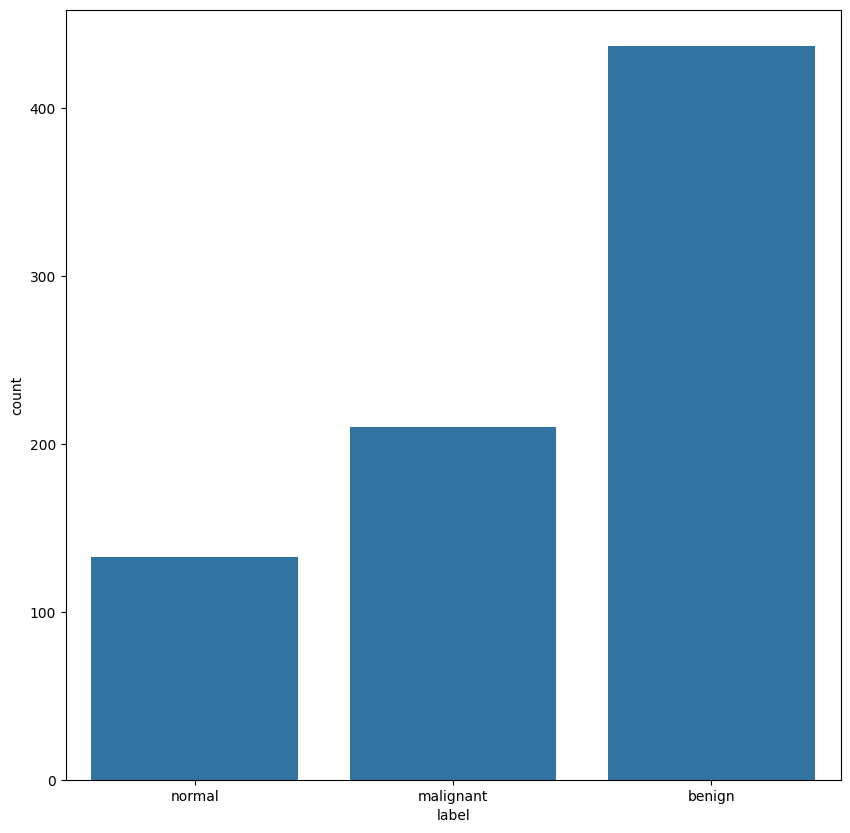

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot
sns.countplot(x='label', data=df)
plt.show()

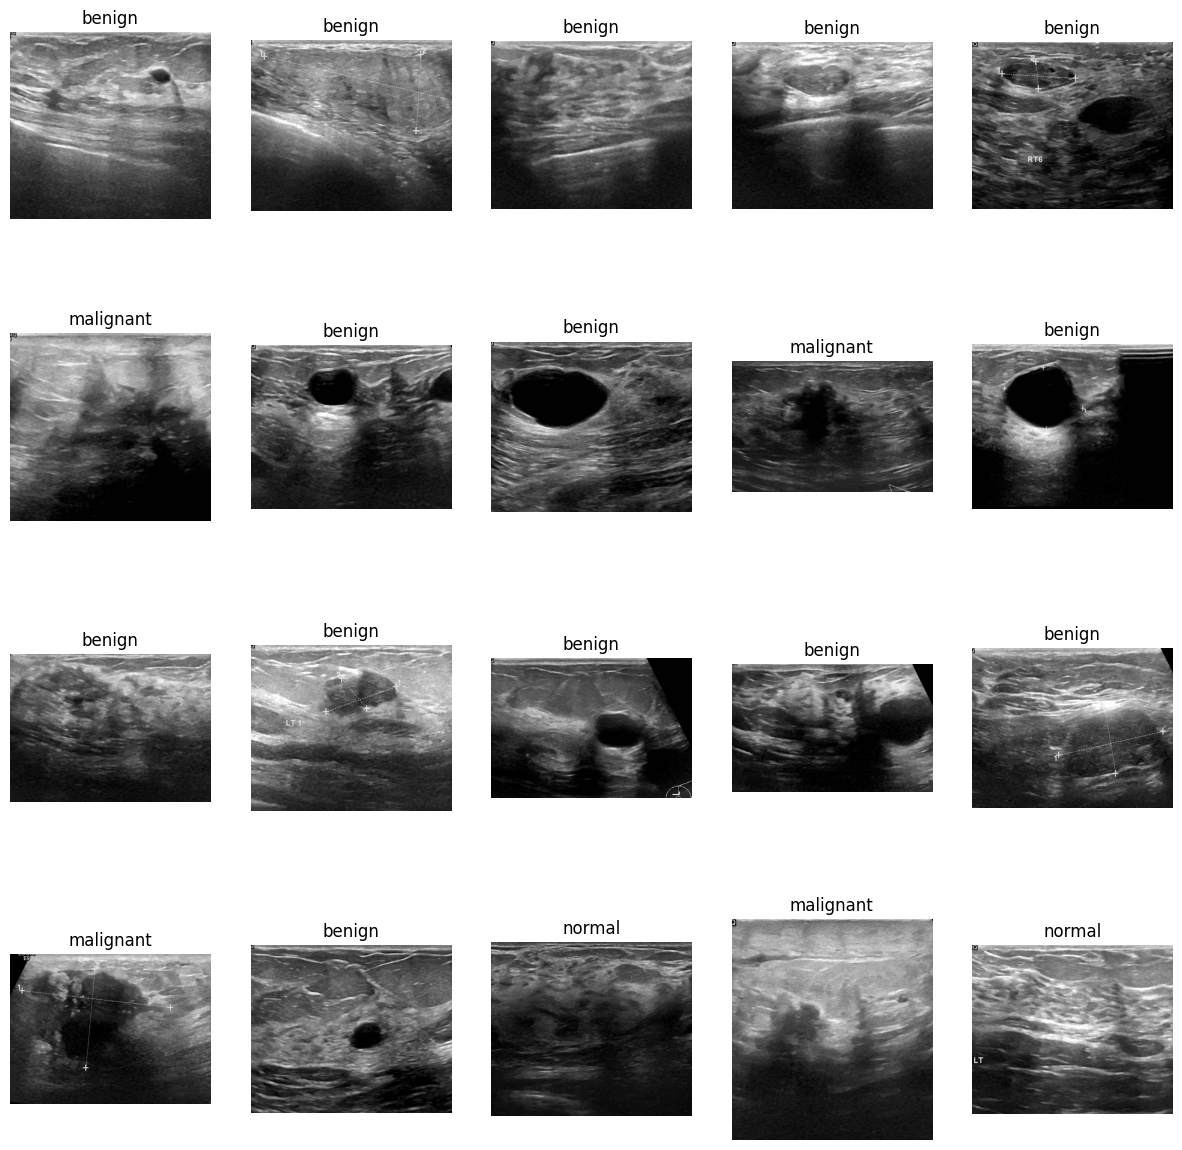

In [ ]:
sample_df = df.sample(n=20, random_state=42)
plt.figure(figsize=(15, 15))
columns = 5
for i, row in enumerate(sample_df.iterrows()):
    file_path = row[1]['file_path']
    label = row[1]['label']
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(4, columns, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis('off')
plt.show()


##Building clases

In [5]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, images: list, labels: list, transform=None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

#se block

In [6]:
class SE_Block(nn.Module):
    def __init__(self, c, r=16):
        super(SE_Block, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excitation = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        bs, c, _, _ = x.size()
        y = self.squeeze(x).view(bs, c)
        y = self.excitation(y).view(bs, c, 1, 1)
        return x * y.expand_as(x)

#Train test split and data loading

In [8]:


img_train = T.Compose(
    [
        T.Resize([250,250]),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ],)

img_val = T.Compose(
    [
        T.Resize([250,250]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ],
)

img_test = T.Compose(
    [
        T.Resize([250,250]),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ],
)

In [9]:
#maping the lables  in df
df['label'] = df['label'].map({'normal': 0, 'malignant': 1, 'benign': 2})

In [11]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)  # 50% val, 50% test
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))
train_df_2=Dataset(images=train_df['file_path'].values,labels=train_df['label'].values,transform=img_train)
val_df_2=Dataset(images=val_df['file_path'].values,labels=val_df['label'].values,transform=img_val)
test_df_2=Dataset(images=test_df['file_path'].values,labels=test_df['label'].values,transform=img_test)


TRAIN Dataset: (611, 2)
VALIDATION Dataset: (76, 2)
TEST Dataset: (77, 2)


In [13]:
#hyperparameters
BATCH_SIZE = 2
epochs = 50
LEARNING_RATE = 1e-3                 #learning rate
gradient_clip = 0.1                 #gradient clipping
weight_decay = 1e-4               #weight decay
patience = 3

In [14]:

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'pin_memory':True
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
               'pin_memory':True
                }
Validation_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                     'pin_memory':True
                }
training_loader = DataLoader(train_df_2, **train_params)
testing_loader = DataLoader(test_df_2, **test_params)
validation_loader = DataLoader(val_df_2, **Validation_params)

#CNN model


Using 4 convolutional layers strikes a balance between model complexity and data limitations. Medical images have subtle details that a shallow model might miss, while 4 layers allow for effective feature extraction without overfitting on a small dataset of 780 images.

In [27]:
class BreastUltrasoundCNN(nn.Module):
    def __init__(self):
        super(BreastUltrasoundCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(28800, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 28800)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x= self.dropout(F.relu(self.fc3(x)))
        x = F.softmax(self.fc4(x), dim=1)
        return x # matrix of probabilitis of batch size*num of clases


#CNN model with se block

In [40]:
class BreastUltrasoundCNN_SE(nn.Module):
    def __init__(self):
        super(BreastUltrasoundCNN_SE, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.se=SE_Block(16)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.se2=SE_Block(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.se3=SE_Block(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,128, kernel_size=3, stride=1, padding=1)
        self.se4=SE_Block(128)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(28800, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 3)
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
      x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))
      x = self.se(x)

      x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
      x = self.se2(x)

      x = self.pool(F.relu(self.bn3(self.conv3(x))))
      x = self.se3(x)
      x = self.pool(F.relu(self.bn4(self.conv4(x))))
      x = self.se4(x)
      x = x.view(-1, 28800)
      x = self.dropout(F.relu(self.fc1(x)))
      x = self.dropout(F.relu(self.fc2(x)))
      x= self.dropout(F.relu(self.fc3(x)))
      x = F.softmax(self.fc4(x), dim=1)
      return x


In [32]:
my_model_cnn = BreastUltrasoundCNN()
my_model_cnn.to(device)

BreastUltrasoundCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=28800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_featur

In [33]:
count_clases=df['label'].value_counts()
count_clases

,count
label,
2,421
1,210
0,133


In [34]:
class_weights = np.array(count_clases/np.sum(count_clases))
class_weights

array([0.55104712, 0.27486911, 0.17408377])

In [35]:
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params =my_model_cnn.parameters(), lr=LEARNING_RATE,weight_decay=1e-3 )
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=50, steps_per_epoch=len(training_loader))



#Training base cnn

##Training function

In [36]:
def my_train(model, train_loader, val_loader, optimizer, loss_function, scheduler, epochs, patience=2, device="cuda"):
    #model_save_path = '/content/drive/MyDrive/best_model_breast_cnn.pt'
    #os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    best_val_loss = float('inf')
    no_improvement_count = 0
    training_losses = []
    validation_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        step = 0
        all_preds, all_labels = [], []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for step, (images, labels) in progress_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            prediction = torch.argmax(outputs, dim=1)
            all_preds.extend(prediction.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss = loss_function(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            if step % 10 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {train_loss/step:.4f},LR:{scheduler.get_last_lr()}")
        # Compute F1 scores for training
        unique_labels = np.unique(all_labels)
        tr_f1_scores = f1_score(all_preds, all_labels, average=None, labels=unique_labels)
        tr_f1_score_dict = {label: score for label, score in zip(unique_labels, tr_f1_scores)}
        tr_macro_f1 = f1_score(all_preds, all_labels, average='macro', labels=unique_labels)
        train_loss_epoch = train_loss / step
        training_losses.append(train_loss_epoch)
        # Validation
        model.eval()
        val_loss = 0
        nb_val_steps = 0
        all_preds_v, all_labels_v = [], []
        with torch.no_grad():
            for val_step, (val_images, val_labels) in enumerate(val_loader):
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs_v = model(val_images)
                loss_v = loss_function(outputs_v, val_labels)
                val_loss += loss_v.item()
                nb_val_steps += 1
                prediction_v = torch.argmax(outputs_v, dim=1)
                all_preds_v.extend(prediction_v.cpu().numpy())
                all_labels_v.extend(val_labels.cpu().numpy())

        # Compute F1 scores for validation
        val_loss_epoch = val_loss / nb_val_steps
        validation_losses.append(val_loss_epoch)
        unique_labels_v = np.unique(all_labels_v)
        val_f1_scores = f1_score(all_preds_v, all_labels_v, average=None, labels=unique_labels_v)
        val_f1_score_dict = {label: score for label, score in zip(unique_labels_v, val_f1_scores)}
        val_macro_f1 = f1_score(all_preds_v, all_labels_v, average='macro', labels=unique_labels_v)

        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss/step:.4f}, Validation Loss: {val_loss_epoch:.4f}")
        print(f"Training F1 Scores: {tr_f1_score_dict}, Validation F1 Scores: {val_f1_score_dict}")
        print(f"Training Macro F1: {tr_macro_f1:.4f}, Validation Macro F1: {val_macro_f1:.4f}")

        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            #torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement_count += 1
        if no_improvement_count >= patience:
            print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
            break

    # Plot training and validation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(training_losses) + 1), training_losses, label="Training Loss")
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss per Epoch')
    plt.legend()
    plt.grid()
    plt.show()
    print("Training and Validation completed!")

#my_train(my_model, training_loader, validation_loader, optimizer, loss_function, sched, epochs, patience=patience, device=device)


Epoch 1/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 1, Step 10, Loss: 1.1029,LR:[4.001124794477924e-06]
Epoch 1, Step 20, Loss: 1.1006,LR:[4.004499125196575e-06]
Epoch 1, Step 30, Loss: 1.1021,LR:[4.0101228340131e-06]
Epoch 1, Step 40, Loss: 1.0957,LR:[4.017995657364307e-06]
Epoch 1, Step 50, Loss: 1.0942,LR:[4.028117226279027e-06]
Epoch 1, Step 60, Loss: 1.0913,LR:[4.040487066395376e-06]
Epoch 1, Step 70, Loss: 1.0905,LR:[4.055104597983054e-06]
Epoch 1, Step 80, Loss: 1.0918,LR:[4.071969135970404e-06]
Epoch 1, Step 90, Loss: 1.0898,LR:[4.0910798899766585e-06]
Epoch 1, Step 100, Loss: 1.0876,LR:[4.112435964348854e-06]
Epoch 1, Step 110, Loss: 1.0869,LR:[4.136036358203912e-06]
Epoch 1, Step 120, Loss: 1.0862,LR:[4.1618799654754624e-06]
Epoch 1, Step 130, Loss: 1.0839,LR:[4.189965574965697e-06]
Epoch 1, Step 140, Loss: 1.0847,LR:[4.220291870402206e-06]
Epoch 1, Step 150, Loss: 1.0824,LR:[4.252857430499593e-06]
Epoch 1, Step 160, Loss: 1.0826,LR:[4.287660729026079e-06]
Epoch 1, Step 170, Loss: 1.0821,LR:[4.3247001348751054e-06]
Epoch

Epoch 2/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 2, Step 10, Loss: 1.0902,LR:[5.118805670506995e-06]
Epoch 2, Step 20, Loss: 1.1062,LR:[5.190437810887244e-06]
Epoch 2, Step 30, Loss: 1.0675,LR:[5.264263748645139e-06]
Epoch 2, Step 40, Loss: 1.0731,LR:[5.340280023822109e-06]
Epoch 2, Step 50, Loss: 1.0757,LR:[5.4184830738061846e-06]
Epoch 2, Step 60, Loss: 1.0670,LR:[5.49886923349907e-06]
Epoch 2, Step 70, Loss: 1.0783,LR:[5.58143473548791e-06]
Epoch 2, Step 80, Loss: 1.0771,LR:[5.666175710221868e-06]
Epoch 2, Step 90, Loss: 1.0778,LR:[5.753088186193439e-06]
Epoch 2, Step 100, Loss: 1.0812,LR:[5.842168090124518e-06]
Epoch 2, Step 110, Loss: 1.0823,LR:[5.933411247157475e-06]
Epoch 2, Step 120, Loss: 1.0733,LR:[6.0268133810506905e-06]
Epoch 2, Step 130, Loss: 1.0657,LR:[6.122370114378944e-06]
Epoch 2, Step 140, Loss: 1.0628,LR:[6.220076968738693e-06]
Epoch 2, Step 150, Loss: 1.0626,LR:[6.319929364957799e-06]
Epoch 2, Step 160, Loss: 1.0603,LR:[6.421922623310323e-06]
Epoch 2, Step 170, Loss: 1.0568,LR:[6.526051963735654e-06]
Epoch 

Epoch 3/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 3, Step 10, Loss: 0.9236,LR:[8.286309504479264e-06]
Epoch 3, Step 20, Loss: 1.0031,LR:[8.423067426679688e-06]
Epoch 3, Step 30, Loss: 1.0110,LR:[8.561867644426915e-06]
Epoch 3, Step 40, Loss: 1.0444,LR:[8.702703652649357e-06]
Epoch 3, Step 50, Loss: 1.0673,LR:[8.845568850865136e-06]
Epoch 3, Step 60, Loss: 1.0599,LR:[8.990456543491509e-06]
Epoch 3, Step 70, Loss: 1.0638,LR:[9.137359940158615e-06]
Epoch 3, Step 80, Loss: 1.0585,LR:[9.286272156027741e-06]
Epoch 3, Step 90, Loss: 1.0613,LR:[9.437186212113977e-06]
Epoch 3, Step 100, Loss: 1.0563,LR:[9.590095035613271e-06]
Epoch 3, Step 110, Loss: 1.0539,LR:[9.74499146023392e-06]
Epoch 3, Step 120, Loss: 1.0561,LR:[9.901868226532497e-06]
Epoch 3, Step 130, Loss: 1.0510,LR:[1.0060717982253981e-05]
Epoch 3, Step 140, Loss: 1.0523,LR:[1.0221533282676356e-05]
Epoch 3, Step 150, Loss: 1.0448,LR:[1.038430659095953e-05]
Epoch 3, Step 160, Loss: 1.0416,LR:[1.0549030278498618e-05]
Epoch 3, Step 170, Loss: 1.0366,LR:[1.071569662528134e-05]
Epoc

Epoch 4/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 4, Step 10, Loss: 0.9971,LR:[1.3365141060274753e-05]
Epoch 4, Step 20, Loss: 1.0592,LR:[1.3561045191193264e-05]
Epoch 4, Step 30, Loss: 1.0468,LR:[1.3758750818949534e-05]
Epoch 4, Step 40, Loss: 1.0236,LR:[1.3958248677785291e-05]
Epoch 4, Step 50, Loss: 1.0053,LR:[1.415952941794679e-05]
Epoch 4, Step 60, Loss: 1.0000,LR:[1.4362583606122964e-05]
Epoch 4, Step 70, Loss: 1.0176,LR:[1.4567401725887607e-05]
Epoch 4, Step 80, Loss: 1.0213,LR:[1.4773974178145286e-05]
Epoch 4, Step 90, Loss: 1.0285,LR:[1.4982291281581266e-05]
Epoch 4, Step 100, Loss: 1.0171,LR:[1.5192343273115255e-05]
Epoch 4, Step 110, Loss: 1.0237,LR:[1.5404120308358873e-05]
Epoch 4, Step 120, Loss: 1.0279,LR:[1.5617612462077158e-05]
Epoch 4, Step 130, Loss: 1.0302,LR:[1.5832809728653615e-05]
Epoch 4, Step 140, Loss: 1.0381,LR:[1.6049702022559193e-05]
Epoch 4, Step 150, Loss: 1.0356,LR:[1.626827917882497e-05]
Epoch 4, Step 160, Loss: 1.0360,LR:[1.6488530953518506e-05]
Epoch 4, Step 170, Loss: 1.0377,LR:[1.6710447024223

Epoch 5/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 5, Step 10, Loss: 1.0189,LR:[2.013323463177201e-05]
Epoch 5, Step 20, Loss: 1.0778,LR:[2.037971930257581e-05]
Epoch 5, Step 30, Loss: 1.0062,LR:[2.0627685903259568e-05]
Epoch 5, Step 40, Loss: 1.0470,LR:[2.0877122812512313e-05]
Epoch 5, Step 50, Loss: 1.0637,LR:[2.112801834011494e-05]
Epoch 5, Step 60, Loss: 1.0484,LR:[2.1380360727488138e-05]
Epoch 5, Step 70, Loss: 1.0426,LR:[2.163413814824339e-05]
Epoch 5, Step 80, Loss: 1.0188,LR:[2.1889338708737334e-05]
Epoch 5, Step 90, Loss: 1.0300,LR:[2.2145950448629074e-05]
Epoch 5, Step 100, Loss: 1.0309,LR:[2.2403961341440747e-05]
Epoch 5, Step 110, Loss: 1.0268,LR:[2.266335929512124e-05]
Epoch 5, Step 120, Loss: 1.0302,LR:[2.29241321526128e-05]
Epoch 5, Step 130, Loss: 1.0429,LR:[2.3186267692420847e-05]
Epoch 5, Step 140, Loss: 1.0393,LR:[2.3449753629186697e-05]
Epoch 5, Step 150, Loss: 1.0301,LR:[2.371457761426345e-05]
Epoch 5, Step 160, Loss: 1.0179,LR:[2.3980727236294565e-05]
Epoch 5, Step 170, Loss: 1.0065,LR:[2.424819002179569e-05

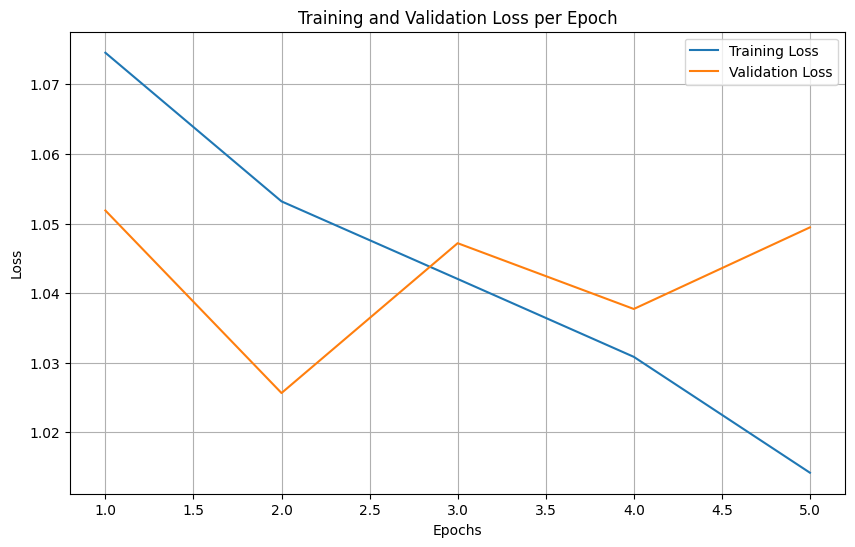

Training and Validation completed!


In [37]:
my_train(my_model_cnn, training_loader, validation_loader, optimizer, loss_function, sched, epochs, patience=patience, device=device)


##Test function

In [38]:
#test set function
def test_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    nb_test_steps = 0
    all_preds_s, all_labels_s = [], []
    model.eval()
    with torch.no_grad():
            for test_step, (test_images, test_labels) in enumerate(test_loader):
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                outputs_s = model(test_images)
                prediction_s = torch.argmax(outputs_s, dim=1)
                all_preds_s.extend(prediction_s.cpu().numpy())
                all_labels_s.extend(test_labels.cpu().numpy())
    unique_labels_s = np.unique(all_labels_s)
    test_f1_scores = f1_score(all_preds_s, all_labels_s, average=None, labels=unique_labels_s)
    test_f1_score_dict = {label: score for label, score in zip(unique_labels_s, test_f1_scores)}
    test_macro_f1 = f1_score(all_preds_s, all_labels_s, average='macro', labels=unique_labels_s)
    print(f"Test F1 Scores: {test_f1_score_dict}")
    print(f"Test Macro F1: {test_macro_f1:.4f}")


In [39]:
test_model(my_model_cnn, testing_loader, device)

Test F1 Scores: {0: 0.0, 1: 0.5625, 2: 0.7105263157894737}
Test Macro F1: 0.4243


#Training CNN with SE block

In [41]:
cnn_se=BreastUltrasoundCNN_SE()
cnn_se.to(device)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params =cnn_se.parameters(), lr=LEARNING_RATE,weight_decay=1e-3 )
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.0001, epochs=50, steps_per_epoch=len(training_loader))

Epoch 1/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 1, Step 10, Loss: 1.0823,LR:[4.001124794477924e-06]
Epoch 1, Step 20, Loss: 1.0829,LR:[4.004499125196575e-06]
Epoch 1, Step 30, Loss: 1.0861,LR:[4.0101228340131e-06]
Epoch 1, Step 40, Loss: 1.0781,LR:[4.017995657364307e-06]
Epoch 1, Step 50, Loss: 1.0807,LR:[4.028117226279027e-06]
Epoch 1, Step 60, Loss: 1.0853,LR:[4.040487066395376e-06]
Epoch 1, Step 70, Loss: 1.0848,LR:[4.055104597983054e-06]
Epoch 1, Step 80, Loss: 1.0865,LR:[4.071969135970404e-06]
Epoch 1, Step 90, Loss: 1.0820,LR:[4.0910798899766585e-06]
Epoch 1, Step 100, Loss: 1.0807,LR:[4.112435964348854e-06]
Epoch 1, Step 110, Loss: 1.0827,LR:[4.136036358203912e-06]
Epoch 1, Step 120, Loss: 1.0828,LR:[4.1618799654754624e-06]
Epoch 1, Step 130, Loss: 1.0848,LR:[4.189965574965697e-06]
Epoch 1, Step 140, Loss: 1.0850,LR:[4.220291870402206e-06]
Epoch 1, Step 150, Loss: 1.0846,LR:[4.252857430499593e-06]
Epoch 1, Step 160, Loss: 1.0824,LR:[4.287660729026079e-06]
Epoch 1, Step 170, Loss: 1.0819,LR:[4.3247001348751054e-06]
Epoch

Epoch 2/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 2, Step 10, Loss: 1.0772,LR:[5.118805670506995e-06]
Epoch 2, Step 20, Loss: 1.0833,LR:[5.190437810887244e-06]
Epoch 2, Step 30, Loss: 1.0599,LR:[5.264263748645139e-06]
Epoch 2, Step 40, Loss: 1.0640,LR:[5.340280023822109e-06]
Epoch 2, Step 50, Loss: 1.0694,LR:[5.4184830738061846e-06]
Epoch 2, Step 60, Loss: 1.0696,LR:[5.49886923349907e-06]
Epoch 2, Step 70, Loss: 1.0668,LR:[5.58143473548791e-06]
Epoch 2, Step 80, Loss: 1.0646,LR:[5.666175710221868e-06]
Epoch 2, Step 90, Loss: 1.0490,LR:[5.753088186193439e-06]
Epoch 2, Step 100, Loss: 1.0315,LR:[5.842168090124518e-06]
Epoch 2, Step 110, Loss: 1.0282,LR:[5.933411247157475e-06]
Epoch 2, Step 120, Loss: 1.0322,LR:[6.0268133810506905e-06]
Epoch 2, Step 130, Loss: 1.0326,LR:[6.122370114378944e-06]
Epoch 2, Step 140, Loss: 1.0334,LR:[6.220076968738693e-06]
Epoch 2, Step 150, Loss: 1.0369,LR:[6.319929364957799e-06]
Epoch 2, Step 160, Loss: 1.0403,LR:[6.421922623310323e-06]
Epoch 2, Step 170, Loss: 1.0495,LR:[6.526051963735654e-06]
Epoch 

Epoch 3/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 3, Step 10, Loss: 1.1001,LR:[8.286309504479264e-06]
Epoch 3, Step 20, Loss: 1.1206,LR:[8.423067426679688e-06]
Epoch 3, Step 30, Loss: 1.0860,LR:[8.561867644426915e-06]
Epoch 3, Step 40, Loss: 1.0883,LR:[8.702703652649357e-06]
Epoch 3, Step 50, Loss: 1.0931,LR:[8.845568850865136e-06]
Epoch 3, Step 60, Loss: 1.0920,LR:[8.990456543491509e-06]
Epoch 3, Step 70, Loss: 1.0938,LR:[9.137359940158615e-06]
Epoch 3, Step 80, Loss: 1.0864,LR:[9.286272156027741e-06]
Epoch 3, Step 90, Loss: 1.0850,LR:[9.437186212113977e-06]
Epoch 3, Step 100, Loss: 1.0743,LR:[9.590095035613271e-06]
Epoch 3, Step 110, Loss: 1.0652,LR:[9.74499146023392e-06]
Epoch 3, Step 120, Loss: 1.0656,LR:[9.901868226532497e-06]
Epoch 3, Step 130, Loss: 1.0684,LR:[1.0060717982253981e-05]
Epoch 3, Step 140, Loss: 1.0639,LR:[1.0221533282676356e-05]
Epoch 3, Step 150, Loss: 1.0582,LR:[1.038430659095953e-05]
Epoch 3, Step 160, Loss: 1.0621,LR:[1.0549030278498618e-05]
Epoch 3, Step 170, Loss: 1.0546,LR:[1.071569662528134e-05]
Epoc

Epoch 4/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 4, Step 10, Loss: 1.0220,LR:[1.3365141060274753e-05]
Epoch 4, Step 20, Loss: 1.0510,LR:[1.3561045191193264e-05]
Epoch 4, Step 30, Loss: 1.0457,LR:[1.3758750818949534e-05]
Epoch 4, Step 40, Loss: 1.0736,LR:[1.3958248677785291e-05]
Epoch 4, Step 50, Loss: 1.0740,LR:[1.415952941794679e-05]
Epoch 4, Step 60, Loss: 1.0790,LR:[1.4362583606122964e-05]
Epoch 4, Step 70, Loss: 1.0736,LR:[1.4567401725887607e-05]
Epoch 4, Step 80, Loss: 1.0784,LR:[1.4773974178145286e-05]
Epoch 4, Step 90, Loss: 1.0714,LR:[1.4982291281581266e-05]
Epoch 4, Step 100, Loss: 1.0616,LR:[1.5192343273115255e-05]
Epoch 4, Step 110, Loss: 1.0455,LR:[1.5404120308358873e-05]
Epoch 4, Step 120, Loss: 1.0398,LR:[1.5617612462077158e-05]
Epoch 4, Step 130, Loss: 1.0385,LR:[1.5832809728653615e-05]
Epoch 4, Step 140, Loss: 1.0362,LR:[1.6049702022559193e-05]
Epoch 4, Step 150, Loss: 1.0252,LR:[1.626827917882497e-05]
Epoch 4, Step 160, Loss: 1.0317,LR:[1.6488530953518506e-05]
Epoch 4, Step 170, Loss: 1.0324,LR:[1.6710447024223

Epoch 5/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 5, Step 10, Loss: 0.9425,LR:[2.013323463177201e-05]
Epoch 5, Step 20, Loss: 1.0085,LR:[2.037971930257581e-05]
Epoch 5, Step 30, Loss: 1.0586,LR:[2.0627685903259568e-05]
Epoch 5, Step 40, Loss: 1.0441,LR:[2.0877122812512313e-05]
Epoch 5, Step 50, Loss: 1.0591,LR:[2.112801834011494e-05]
Epoch 5, Step 60, Loss: 1.0475,LR:[2.1380360727488138e-05]
Epoch 5, Step 70, Loss: 1.0375,LR:[2.163413814824339e-05]
Epoch 5, Step 80, Loss: 1.0432,LR:[2.1889338708737334e-05]
Epoch 5, Step 90, Loss: 1.0460,LR:[2.2145950448629074e-05]
Epoch 5, Step 100, Loss: 1.0412,LR:[2.2403961341440747e-05]
Epoch 5, Step 110, Loss: 1.0444,LR:[2.266335929512124e-05]
Epoch 5, Step 120, Loss: 1.0452,LR:[2.29241321526128e-05]
Epoch 5, Step 130, Loss: 1.0414,LR:[2.3186267692420847e-05]
Epoch 5, Step 140, Loss: 1.0370,LR:[2.3449753629186697e-05]
Epoch 5, Step 150, Loss: 1.0350,LR:[2.371457761426345e-05]
Epoch 5, Step 160, Loss: 1.0366,LR:[2.3980727236294565e-05]
Epoch 5, Step 170, Loss: 1.0322,LR:[2.424819002179569e-05

Epoch 6/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 6, Step 10, Loss: 1.0270,LR:[2.8294663594600992e-05]
Epoch 6, Step 20, Loss: 0.9258,LR:[2.858095156413356e-05]
Epoch 6, Step 30, Loss: 0.9606,LR:[2.8868337101014416e-05]
Epoch 6, Step 40, Loss: 0.9284,LR:[2.9156806736507516e-05]
Epoch 6, Step 50, Loss: 0.9592,LR:[2.9446346951068992e-05]
Epoch 6, Step 60, Loss: 0.9850,LR:[2.9736944174980727e-05]
Epoch 6, Step 70, Loss: 0.9983,LR:[3.0028584788986364e-05]
Epoch 6, Step 80, Loss: 0.9886,LR:[3.032125512492956e-05]
Epoch 6, Step 90, Loss: 0.9886,LR:[3.061494146639458e-05]
Epoch 6, Step 100, Loss: 0.9868,LR:[3.090963004934912e-05]
Epoch 6, Step 110, Loss: 0.9828,LR:[3.1205307062789404e-05]
Epoch 6, Step 120, Loss: 0.9778,LR:[3.1501958649387434e-05]
Epoch 6, Step 130, Loss: 0.9870,LR:[3.179957090614042e-05]
Epoch 6, Step 140, Loss: 0.9962,LR:[3.2098129885022446e-05]
Epoch 6, Step 150, Loss: 0.9980,LR:[3.2397621593638034e-05]
Epoch 6, Step 160, Loss: 1.0009,LR:[3.269803199587801e-05]
Epoch 6, Step 170, Loss: 1.0039,LR:[3.299934701257734e-

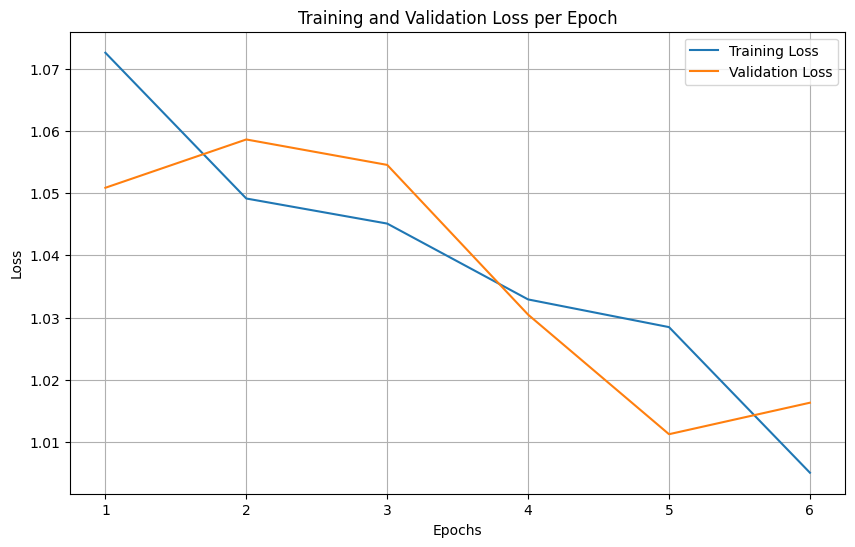

Training and Validation completed!


In [42]:

#training :
my_train(cnn_se, training_loader, validation_loader, optimizer, loss_function, sched, epochs, patience=patience, device=device)

In [44]:
#testing
test_model(cnn_se, testing_loader, device)

Test F1 Scores: {0: 0.0, 1: 0.717948717948718, 2: 0.7920792079207921}
Test Macro F1: 0.5033


#RESNET50

In [45]:
from torchvision.models import resnet50
model_my = resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [46]:
from torchvision.models import ResNet50_Weights
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()
img_train_res=T.Compose([T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),preprocess])

In [48]:
class ResNet50Model(nn.Module):
  def __init__(self):
    super(ResNet50Model, self).__init__()
    self.resnet =resnet50(pretrained=True)
    self.dropout = torch.nn.Dropout(0.3)
    self.fc1=torch.nn.Linear(1000,3)
  def forward(self,x):
    x=self.resnet(x)
    x=F.relu(x)
    x=self.dropout(x)
    x = F.softmax(self.fc1(x), dim=1)
    return x


In [59]:
my_resnet=ResNet50Model()
my_resnet.to(device)

ResNet50Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
     

In [60]:
transform_my = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [61]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)  # 50% val, 50% test
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))
train_df_2=Dataset(images=train_df['file_path'].values,labels=train_df['label'].values,transform=img_train_res)
val_df_2=Dataset(images=val_df['file_path'].values,labels=val_df['label'].values,transform=preprocess)
test_df_2=Dataset(images=test_df['file_path'].values,labels=test_df['label'].values,transform=preprocess)


TRAIN Dataset: (611, 2)
VALIDATION Dataset: (76, 2)
TEST Dataset: (77, 2)


In [62]:

train_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'pin_memory':True
                }

test_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
               'pin_memory':True
                }
Validation_params = {'batch_size': BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                     'pin_memory':True
                }
training_loader = DataLoader(train_df_2, **train_params)
testing_loader = DataLoader(test_df_2, **test_params)
validation_loader = DataLoader(val_df_2, **Validation_params)

In [64]:
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params =my_resnet.parameters(), lr=LEARNING_RATE,weight_decay=1e-3 )
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.0001, epochs=50, steps_per_epoch=len(training_loader))

Epoch 1/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 1, Step 10, Loss: 1.1030,LR:[4.001124794477924e-06]
Epoch 1, Step 20, Loss: 1.1041,LR:[4.004499125196575e-06]
Epoch 1, Step 30, Loss: 1.1046,LR:[4.0101228340131e-06]
Epoch 1, Step 40, Loss: 1.0968,LR:[4.017995657364307e-06]
Epoch 1, Step 50, Loss: 1.0973,LR:[4.028117226279027e-06]
Epoch 1, Step 60, Loss: 1.0934,LR:[4.040487066395376e-06]
Epoch 1, Step 70, Loss: 1.0986,LR:[4.055104597983054e-06]
Epoch 1, Step 80, Loss: 1.1014,LR:[4.071969135970404e-06]
Epoch 1, Step 90, Loss: 1.0968,LR:[4.0910798899766585e-06]
Epoch 1, Step 100, Loss: 1.0955,LR:[4.112435964348854e-06]
Epoch 1, Step 110, Loss: 1.0913,LR:[4.136036358203912e-06]
Epoch 1, Step 120, Loss: 1.0896,LR:[4.1618799654754624e-06]
Epoch 1, Step 130, Loss: 1.0881,LR:[4.189965574965697e-06]
Epoch 1, Step 140, Loss: 1.0865,LR:[4.220291870402206e-06]
Epoch 1, Step 150, Loss: 1.0853,LR:[4.252857430499593e-06]
Epoch 1, Step 160, Loss: 1.0823,LR:[4.287660729026079e-06]
Epoch 1, Step 170, Loss: 1.0830,LR:[4.3247001348751054e-06]
Epoch

Epoch 2/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 2, Step 10, Loss: 1.0343,LR:[5.118805670506995e-06]
Epoch 2, Step 20, Loss: 1.0185,LR:[5.190437810887244e-06]
Epoch 2, Step 30, Loss: 1.0361,LR:[5.264263748645139e-06]
Epoch 2, Step 40, Loss: 1.0321,LR:[5.340280023822109e-06]
Epoch 2, Step 50, Loss: 1.0377,LR:[5.4184830738061846e-06]
Epoch 2, Step 60, Loss: 1.0207,LR:[5.49886923349907e-06]
Epoch 2, Step 70, Loss: 1.0125,LR:[5.58143473548791e-06]
Epoch 2, Step 80, Loss: 1.0136,LR:[5.666175710221868e-06]
Epoch 2, Step 90, Loss: 1.0064,LR:[5.753088186193439e-06]
Epoch 2, Step 100, Loss: 1.0140,LR:[5.842168090124518e-06]
Epoch 2, Step 110, Loss: 1.0133,LR:[5.933411247157475e-06]
Epoch 2, Step 120, Loss: 1.0101,LR:[6.0268133810506905e-06]
Epoch 2, Step 130, Loss: 1.0068,LR:[6.122370114378944e-06]
Epoch 2, Step 140, Loss: 1.0017,LR:[6.220076968738693e-06]
Epoch 2, Step 150, Loss: 1.0043,LR:[6.319929364957799e-06]
Epoch 2, Step 160, Loss: 1.0021,LR:[6.421922623310323e-06]
Epoch 2, Step 170, Loss: 1.0038,LR:[6.526051963735654e-06]
Epoch 

Epoch 3/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 3, Step 10, Loss: 0.9482,LR:[8.286309504479264e-06]
Epoch 3, Step 20, Loss: 0.9774,LR:[8.423067426679688e-06]
Epoch 3, Step 30, Loss: 0.9922,LR:[8.561867644426915e-06]
Epoch 3, Step 40, Loss: 0.9954,LR:[8.702703652649357e-06]
Epoch 3, Step 50, Loss: 0.9995,LR:[8.845568850865136e-06]
Epoch 3, Step 60, Loss: 1.0002,LR:[8.990456543491509e-06]
Epoch 3, Step 70, Loss: 1.0032,LR:[9.137359940158615e-06]
Epoch 3, Step 80, Loss: 1.0030,LR:[9.286272156027741e-06]
Epoch 3, Step 90, Loss: 1.0069,LR:[9.437186212113977e-06]
Epoch 3, Step 100, Loss: 1.0103,LR:[9.590095035613271e-06]
Epoch 3, Step 110, Loss: 1.0047,LR:[9.74499146023392e-06]
Epoch 3, Step 120, Loss: 1.0045,LR:[9.901868226532497e-06]
Epoch 3, Step 130, Loss: 1.0011,LR:[1.0060717982253981e-05]
Epoch 3, Step 140, Loss: 0.9933,LR:[1.0221533282676356e-05]
Epoch 3, Step 150, Loss: 0.9916,LR:[1.038430659095953e-05]
Epoch 3, Step 160, Loss: 0.9891,LR:[1.0549030278498618e-05]
Epoch 3, Step 170, Loss: 0.9843,LR:[1.071569662528134e-05]
Epoc

Epoch 4/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 4, Step 10, Loss: 0.9060,LR:[1.3365141060274753e-05]
Epoch 4, Step 20, Loss: 0.9476,LR:[1.3561045191193264e-05]
Epoch 4, Step 30, Loss: 0.9130,LR:[1.3758750818949534e-05]
Epoch 4, Step 40, Loss: 0.9215,LR:[1.3958248677785291e-05]
Epoch 4, Step 50, Loss: 0.9154,LR:[1.415952941794679e-05]
Epoch 4, Step 60, Loss: 0.9256,LR:[1.4362583606122964e-05]
Epoch 4, Step 70, Loss: 0.9308,LR:[1.4567401725887607e-05]
Epoch 4, Step 80, Loss: 0.9204,LR:[1.4773974178145286e-05]
Epoch 4, Step 90, Loss: 0.9154,LR:[1.4982291281581266e-05]
Epoch 4, Step 100, Loss: 0.9204,LR:[1.5192343273115255e-05]
Epoch 4, Step 110, Loss: 0.9104,LR:[1.5404120308358873e-05]
Epoch 4, Step 120, Loss: 0.9082,LR:[1.5617612462077158e-05]
Epoch 4, Step 130, Loss: 0.9080,LR:[1.5832809728653615e-05]
Epoch 4, Step 140, Loss: 0.9146,LR:[1.6049702022559193e-05]
Epoch 4, Step 150, Loss: 0.9198,LR:[1.626827917882497e-05]
Epoch 4, Step 160, Loss: 0.9246,LR:[1.6488530953518506e-05]
Epoch 4, Step 170, Loss: 0.9211,LR:[1.6710447024223

Epoch 5/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 5, Step 10, Loss: 0.8310,LR:[2.013323463177201e-05]
Epoch 5, Step 20, Loss: 0.8107,LR:[2.037971930257581e-05]
Epoch 5, Step 30, Loss: 0.8393,LR:[2.0627685903259568e-05]
Epoch 5, Step 40, Loss: 0.8383,LR:[2.0877122812512313e-05]
Epoch 5, Step 50, Loss: 0.8415,LR:[2.112801834011494e-05]
Epoch 5, Step 60, Loss: 0.8465,LR:[2.1380360727488138e-05]
Epoch 5, Step 70, Loss: 0.8453,LR:[2.163413814824339e-05]
Epoch 5, Step 80, Loss: 0.8430,LR:[2.1889338708737334e-05]
Epoch 5, Step 90, Loss: 0.8361,LR:[2.2145950448629074e-05]
Epoch 5, Step 100, Loss: 0.8237,LR:[2.2403961341440747e-05]
Epoch 5, Step 110, Loss: 0.8389,LR:[2.266335929512124e-05]
Epoch 5, Step 120, Loss: 0.8342,LR:[2.29241321526128e-05]
Epoch 5, Step 130, Loss: 0.8413,LR:[2.3186267692420847e-05]
Epoch 5, Step 140, Loss: 0.8464,LR:[2.3449753629186697e-05]
Epoch 5, Step 150, Loss: 0.8535,LR:[2.371457761426345e-05]
Epoch 5, Step 160, Loss: 0.8545,LR:[2.3980727236294565e-05]
Epoch 5, Step 170, Loss: 0.8571,LR:[2.424819002179569e-05

Epoch 6/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 6, Step 10, Loss: 0.7272,LR:[2.8294663594600992e-05]
Epoch 6, Step 20, Loss: 0.7759,LR:[2.858095156413356e-05]
Epoch 6, Step 30, Loss: 0.8095,LR:[2.8868337101014416e-05]
Epoch 6, Step 40, Loss: 0.8297,LR:[2.9156806736507516e-05]
Epoch 6, Step 50, Loss: 0.8454,LR:[2.9446346951068992e-05]
Epoch 6, Step 60, Loss: 0.8357,LR:[2.9736944174980727e-05]
Epoch 6, Step 70, Loss: 0.8349,LR:[3.0028584788986364e-05]
Epoch 6, Step 80, Loss: 0.8373,LR:[3.032125512492956e-05]
Epoch 6, Step 90, Loss: 0.8505,LR:[3.061494146639458e-05]
Epoch 6, Step 100, Loss: 0.8667,LR:[3.090963004934912e-05]
Epoch 6, Step 110, Loss: 0.8626,LR:[3.1205307062789404e-05]
Epoch 6, Step 120, Loss: 0.8576,LR:[3.1501958649387434e-05]
Epoch 6, Step 130, Loss: 0.8517,LR:[3.179957090614042e-05]
Epoch 6, Step 140, Loss: 0.8434,LR:[3.2098129885022446e-05]
Epoch 6, Step 150, Loss: 0.8343,LR:[3.2397621593638034e-05]
Epoch 6, Step 160, Loss: 0.8458,LR:[3.269803199587801e-05]
Epoch 6, Step 170, Loss: 0.8468,LR:[3.299934701257734e-

Epoch 7/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 7, Step 10, Loss: 0.9025,LR:[3.7492579436327274e-05]
Epoch 7, Step 20, Loss: 0.9115,LR:[3.7806153112813833e-05]
Epoch 7, Step 30, Loss: 0.8919,LR:[3.812039200432534e-05]
Epoch 7, Step 40, Loss: 0.8676,LR:[3.843528138360475e-05]
Epoch 7, Step 50, Loss: 0.8855,LR:[3.875080649290892e-05]
Epoch 7, Step 60, Loss: 0.8812,LR:[3.9066952544700304e-05]
Epoch 7, Step 70, Loss: 0.8667,LR:[3.938370472234006e-05]
Epoch 7, Step 80, Loss: 0.8736,LR:[3.970104818078232e-05]
Epoch 7, Step 90, Loss: 0.8848,LR:[4.001896804727002e-05]
Epoch 7, Step 100, Loss: 0.8748,LR:[4.033744942203189e-05]
Epoch 7, Step 110, Loss: 0.8714,LR:[4.0656477378980765e-05]
Epoch 7, Step 120, Loss: 0.8778,LR:[4.097603696641319e-05]
Epoch 7, Step 130, Loss: 0.8803,LR:[4.129611320770995e-05]
Epoch 7, Step 140, Loss: 0.8828,LR:[4.161669110203824e-05]
Epoch 7, Step 150, Loss: 0.8952,LR:[4.1937755625054486e-05]
Epoch 7, Step 160, Loss: 0.9038,LR:[4.225929172960859e-05]
Epoch 7, Step 170, Loss: 0.8923,LR:[4.258128434644909e-05]
E

Epoch 8/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 8, Step 10, Loss: 0.7375,LR:[4.732481452177737e-05]
Epoch 8, Step 20, Loss: 0.7711,LR:[4.765196327923532e-05]
Epoch 8, Step 30, Loss: 0.8145,LR:[4.797931581368047e-05]
Epoch 8, Step 40, Loss: 0.8243,LR:[4.8306856783266074e-05]
Epoch 8, Step 50, Loss: 0.8045,LR:[4.863457083731403e-05]
Epoch 8, Step 60, Loss: 0.8117,LR:[4.896244261703437e-05]
Epoch 8, Step 70, Loss: 0.8475,LR:[4.929045675624518e-05]
Epoch 8, Step 80, Loss: 0.8645,LR:[4.961859788209258e-05]
Epoch 8, Step 90, Loss: 0.8742,LR:[4.994685061577132e-05]
Epoch 8, Step 100, Loss: 0.8602,LR:[5.0275199573245464e-05]
Epoch 8, Step 110, Loss: 0.8655,LR:[5.06036293659694e-05]
Epoch 8, Step 120, Loss: 0.8699,LR:[5.0932124601609114e-05]
Epoch 8, Step 130, Loss: 0.8741,LR:[5.1260669884763465e-05]
Epoch 8, Step 140, Loss: 0.8811,LR:[5.1589249817685774e-05]
Epoch 8, Step 150, Loss: 0.8815,LR:[5.1917849001005455e-05]
Epoch 8, Step 160, Loss: 0.8804,LR:[5.22464520344497e-05]
Epoch 8, Step 170, Loss: 0.8725,LR:[5.2575043517565315e-05]
E

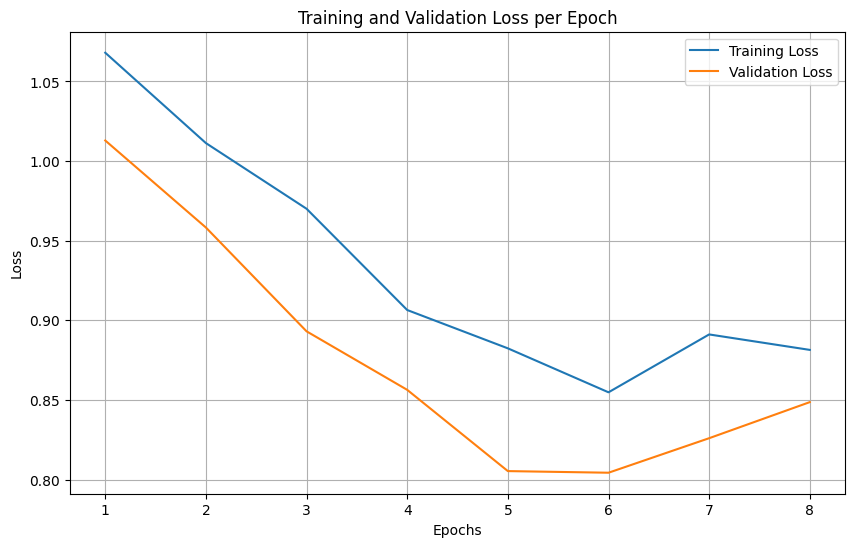

Training and Validation completed!


In [65]:
my_train(my_resnet, training_loader, validation_loader, optimizer, loss_function, sched, epochs, patience=2, device=device)

In [66]:
#testing
test_model(my_resnet, testing_loader, device)

Test F1 Scores: {0: 0.8, 1: 0.5714285714285714, 2: 0.8571428571428571}
Test Macro F1: 0.7429


#VGG19

In [68]:
model = models.vgg19(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 217MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [70]:
class my_vgg19(nn.Module):
  def __init__(self):
    super(my_vgg19, self).__init__()
    self.vgg =model
    self.dropout = torch.nn.Dropout(0.3)
    self.fc1=nn.Linear(1000,3)
  def forward(self,x):
    x=self.vgg(x)
    x=F.relu(x)
    x=self.dropout(x)
    x = F.softmax(self.fc1(x), dim=1)
    return x
my_vgg=my_vgg19()
my_vgg.to(device)

my_vgg19(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): C

In [71]:
loss_function = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params =my_vgg.parameters(), lr=LEARNING_RATE,weight_decay=1e-3 )
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.00001, epochs=50, steps_per_epoch=len(training_loader))

Epoch 1/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 1, Step 10, Loss: 0.9966,LR:[4.001124794477914e-07]
Epoch 1, Step 20, Loss: 1.0308,LR:[4.004499125196558e-07]
Epoch 1, Step 30, Loss: 1.0710,LR:[4.0101228340130964e-07]
Epoch 1, Step 40, Loss: 1.0683,LR:[4.0179956573643005e-07]
Epoch 1, Step 50, Loss: 1.0800,LR:[4.02811722627901e-07]
Epoch 1, Step 60, Loss: 1.0911,LR:[4.040487066395363e-07]
Epoch 1, Step 70, Loss: 1.0895,LR:[4.055104597983037e-07]
Epoch 1, Step 80, Loss: 1.0915,LR:[4.0719691359703903e-07]
Epoch 1, Step 90, Loss: 1.0971,LR:[4.0910798899766484e-07]
Epoch 1, Step 100, Loss: 1.0862,LR:[4.112435964348851e-07]
Epoch 1, Step 110, Loss: 1.0868,LR:[4.1360363582038985e-07]
Epoch 1, Step 120, Loss: 1.0828,LR:[4.1618799654754455e-07]
Epoch 1, Step 130, Loss: 1.0835,LR:[4.1899655749656866e-07]
Epoch 1, Step 140, Loss: 1.0873,LR:[4.22029187040221e-07]
Epoch 1, Step 150, Loss: 1.0854,LR:[4.252857430499593e-07]
Epoch 1, Step 160, Loss: 1.0823,LR:[4.2876607290260825e-07]
Epoch 1, Step 170, Loss: 1.0827,LR:[4.3247001348750987e-07]

Epoch 2/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 2, Step 10, Loss: 1.0946,LR:[5.118805670506988e-07]
Epoch 2, Step 20, Loss: 1.0742,LR:[5.190437810887241e-07]
Epoch 2, Step 30, Loss: 1.0788,LR:[5.264263748645139e-07]
Epoch 2, Step 40, Loss: 1.0696,LR:[5.340280023822109e-07]
Epoch 2, Step 50, Loss: 1.0676,LR:[5.418483073806181e-07]
Epoch 2, Step 60, Loss: 1.0575,LR:[5.498869233499056e-07]
Epoch 2, Step 70, Loss: 1.0674,LR:[5.581434735487904e-07]
Epoch 2, Step 80, Loss: 1.0573,LR:[5.666175710221864e-07]
Epoch 2, Step 90, Loss: 1.0570,LR:[5.753088186193418e-07]
Epoch 2, Step 100, Loss: 1.0583,LR:[5.842168090124511e-07]
Epoch 2, Step 110, Loss: 1.0532,LR:[5.933411247157475e-07]
Epoch 2, Step 120, Loss: 1.0545,LR:[6.026813381050677e-07]
Epoch 2, Step 130, Loss: 1.0551,LR:[6.122370114378944e-07]
Epoch 2, Step 140, Loss: 1.0516,LR:[6.220076968738679e-07]
Epoch 2, Step 150, Loss: 1.0525,LR:[6.319929364957792e-07]
Epoch 2, Step 160, Loss: 1.0545,LR:[6.42192262331032e-07]
Epoch 2, Step 170, Loss: 1.0564,LR:[6.526051963735637e-07]
Epoch 2

Epoch 3/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 3, Step 10, Loss: 0.9534,LR:[8.286309504479244e-07]
Epoch 3, Step 20, Loss: 1.0121,LR:[8.423067426679681e-07]
Epoch 3, Step 30, Loss: 1.0004,LR:[8.561867644426918e-07]
Epoch 3, Step 40, Loss: 0.9965,LR:[8.702703652649357e-07]
Epoch 3, Step 50, Loss: 1.0118,LR:[8.845568850865119e-07]
Epoch 3, Step 60, Loss: 1.0206,LR:[8.990456543491495e-07]
Epoch 3, Step 70, Loss: 1.0293,LR:[9.137359940158609e-07]
Epoch 3, Step 80, Loss: 1.0305,LR:[9.286272156027741e-07]
Epoch 3, Step 90, Loss: 1.0409,LR:[9.43718621211397e-07]
Epoch 3, Step 100, Loss: 1.0339,LR:[9.59009503561326e-07]
Epoch 3, Step 110, Loss: 1.0309,LR:[9.744991460233923e-07]
Epoch 3, Step 120, Loss: 1.0403,LR:[9.901868226532497e-07]
Epoch 3, Step 130, Loss: 1.0434,LR:[1.0060717982253971e-06]
Epoch 3, Step 140, Loss: 1.0428,LR:[1.0221533282676339e-06]
Epoch 3, Step 150, Loss: 1.0447,LR:[1.0384306590959523e-06]
Epoch 3, Step 160, Loss: 1.0458,LR:[1.0549030278498611e-06]
Epoch 3, Step 170, Loss: 1.0536,LR:[1.071569662528133e-06]
Epoc

Epoch 4/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 4, Step 10, Loss: 1.0643,LR:[1.3365141060274743e-06]
Epoch 4, Step 20, Loss: 1.0359,LR:[1.356104519119327e-06]
Epoch 4, Step 30, Loss: 1.0021,LR:[1.3758750818949534e-06]
Epoch 4, Step 40, Loss: 1.0128,LR:[1.3958248677785274e-06]
Epoch 4, Step 50, Loss: 1.0061,LR:[1.4159529417946786e-06]
Epoch 4, Step 60, Loss: 1.0124,LR:[1.4362583606122954e-06]
Epoch 4, Step 70, Loss: 0.9778,LR:[1.4567401725887603e-06]
Epoch 4, Step 80, Loss: 0.9850,LR:[1.477397417814528e-06]
Epoch 4, Step 90, Loss: 0.9844,LR:[1.498229128158126e-06]
Epoch 4, Step 100, Loss: 0.9872,LR:[1.5192343273115238e-06]
Epoch 4, Step 110, Loss: 0.9908,LR:[1.540412030835888e-06]
Epoch 4, Step 120, Loss: 0.9895,LR:[1.5617612462077148e-06]
Epoch 4, Step 130, Loss: 0.9873,LR:[1.5832809728653608e-06]
Epoch 4, Step 140, Loss: 0.9897,LR:[1.60497020225592e-06]
Epoch 4, Step 150, Loss: 0.9873,LR:[1.6268279178824963e-06]
Epoch 4, Step 160, Loss: 0.9838,LR:[1.648853095351851e-06]
Epoch 4, Step 170, Loss: 0.9869,LR:[1.6710447024223987e-

Epoch 5/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 5, Step 10, Loss: 1.1115,LR:[2.0133234631772e-06]
Epoch 5, Step 20, Loss: 1.0006,LR:[2.0379719302575804e-06]
Epoch 5, Step 30, Loss: 0.9987,LR:[2.062768590325956e-06]
Epoch 5, Step 40, Loss: 0.9828,LR:[2.0877122812512303e-06]
Epoch 5, Step 50, Loss: 0.9495,LR:[2.1128018340114934e-06]
Epoch 5, Step 60, Loss: 0.9376,LR:[2.138036072748813e-06]
Epoch 5, Step 70, Loss: 0.9459,LR:[2.163413814824339e-06]
Epoch 5, Step 80, Loss: 0.9430,LR:[2.188933870873732e-06]
Epoch 5, Step 90, Loss: 0.9332,LR:[2.2145950448629057e-06]
Epoch 5, Step 100, Loss: 0.9362,LR:[2.2403961341440747e-06]
Epoch 5, Step 110, Loss: 0.9349,LR:[2.266335929512123e-06]
Epoch 5, Step 120, Loss: 0.9189,LR:[2.2924132152612796e-06]
Epoch 5, Step 130, Loss: 0.9031,LR:[2.318626769242083e-06]
Epoch 5, Step 140, Loss: 0.9027,LR:[2.3449753629186697e-06]
Epoch 5, Step 150, Loss: 0.8998,LR:[2.3714577614263444e-06]
Epoch 5, Step 160, Loss: 0.8909,LR:[2.3980727236294567e-06]
Epoch 5, Step 170, Loss: 0.8956,LR:[2.4248190021795695e-06

Epoch 6/50:   0%|          | 0/306 [00:00<?, ?it/s]

Epoch 6, Step 10, Loss: 0.7964,LR:[2.8294663594600984e-06]
Epoch 6, Step 20, Loss: 0.8515,LR:[2.858095156413356e-06]
Epoch 6, Step 30, Loss: 0.8327,LR:[2.8868337101014412e-06]
Epoch 6, Step 40, Loss: 0.8409,LR:[2.9156806736507512e-06]
Epoch 6, Step 50, Loss: 0.8322,LR:[2.944634695106899e-06]
Epoch 6, Step 60, Loss: 0.8236,LR:[2.9736944174980727e-06]
Epoch 6, Step 70, Loss: 0.8225,LR:[3.002858478898636e-06]
Epoch 6, Step 80, Loss: 0.8284,LR:[3.0321255124929558e-06]
Epoch 6, Step 90, Loss: 0.8133,LR:[3.0614941466394565e-06]
Epoch 6, Step 100, Loss: 0.8171,LR:[3.0909630049349115e-06]
Epoch 6, Step 110, Loss: 0.8217,LR:[3.12053070627894e-06]
Epoch 6, Step 120, Loss: 0.8182,LR:[3.150195864938743e-06]
Epoch 6, Step 130, Loss: 0.8178,LR:[3.1799570906140413e-06]
Epoch 6, Step 140, Loss: 0.8185,LR:[3.2098129885022434e-06]
Epoch 6, Step 150, Loss: 0.8237,LR:[3.2397621593638027e-06]
Epoch 6, Step 160, Loss: 0.8284,LR:[3.269803199587801e-06]
Epoch 6, Step 170, Loss: 0.8237,LR:[3.2999347012577334e-

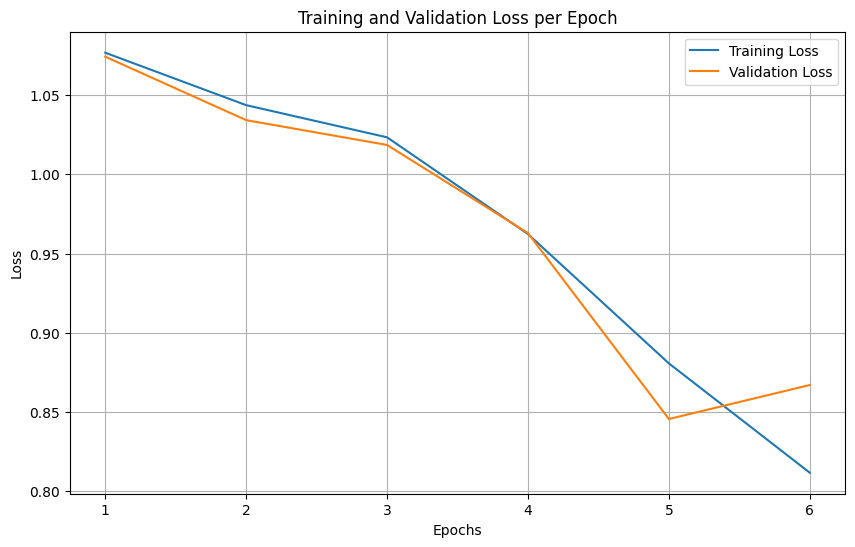

Training and Validation completed!


In [72]:
#training
my_train(my_vgg, training_loader, validation_loader, optimizer, loss_function, sched, epochs, patience=1, device=device)

In [73]:
#testing
test_model(my_vgg, testing_loader, device)

Test F1 Scores: {0: 0.6829268292682927, 1: 0.7692307692307693, 2: 0.7837837837837838}
Test Macro F1: 0.7453


#Results of classifications

In [75]:
data = {
    'CNN': [0, 0.5625, 0.7105263157894737, 0.4243],
    'CNN SE BLOCK': [0, 0.717948717948718, 0.7920792079207921, 0.5033],
    'RESNET50': [0.8, 0.5714285714285714, 0.5714285714285714, 0.7429],
    'VGG19': [0.6829268292682927, 0.7692307692307693, 0.8571428571428571, 0.7453]
}


index = ['normal_f1_score', 'malignant_f1_score', 'benign_f1_score', 'macro_f1_score']


df_results = pd.DataFrame(data, index=index)


df_results

,CNN,CNN SE BLOCK,RESNET50,VGG19
normal_f1_score,0.000000,0.000000,0.800000,0.682927
malignant_f1_score,0.562500,0.717949,0.571429,0.769231
benign_f1_score,0.710526,0.792079,0.571429,0.857143
macro_f1_score,0.424300,0.503300,0.742900,0.745300


After experimenting with various models, we observe that simple architectures like a basic CNN and an upgraded CNN with an SE block fail to deliver satisfactory results. This is primarily due to the limited amount of training data, making it challenging for these models to learn effectively.

However, when transitioning to more complex and deeper models, particularly pretrained ones, there is a noticeable improvement in performance. Among these, VGG19 stands out as the best-performing model. While its results are not perfect, it demonstrates significant improvement in classification abilities, as reflected in the F1 scores for each class, including the under represented classes "normal" and "malignant."

#Breast Cancer Image Segmentation | Attention UNet

In [3]:
import os
import re
import pandas as pd

base_dir = '/content/drive/MyDrive/Dataset_BUSI_with_GT'
folders = {'normal': 'normal', 'malignant': 'malignant', 'benign': 'benign'}

def get_base_filename(filename):
    return re.sub(r'_mask(_\d+)?\.png$', '.png', filename)

def process_images():
    image_paths = []
    mask_paths = []

    for folder_name, label in folders.items():
        folder_path = os.path.join(base_dir, folder_name)
        files = os.listdir(folder_path)

        # Group files by their base name
        file_groups = {}
        for file in files:
            base_name = get_base_filename(file)
            if base_name not in file_groups:
                file_groups[base_name] = []
            file_groups[base_name].append(file)

        # Process each group
        for base_name, group in file_groups.items():
            if len(group) == 2:  # One original image and one mask
                original_image = next(f for f in group if not f.endswith('_mask.png'))
                mask_image = next(f for f in group if f.endswith('_mask.png'))

                image_paths.append(os.path.join(folder_path, original_image))
                mask_paths.append(os.path.join(folder_path, mask_image))
            elif len(group) > 2:  # More than one mask file
                print(f"Removing group due to multiple masks: {group}")
                for file in group:
                    file_path = os.path.join(folder_path, file)
                    try:
                        os.remove(file_path)
                        print(f"Deleted: {file_path}")
                    except OSError as e:
                        print(f"Error deleting {file_path}: {e}")

    return image_paths, mask_paths

# Process images and create DataFrame
image_paths, mask_paths = process_images()

df_segmentation = pd.DataFrame({
    'image_path': image_paths,
    'mask_path': mask_paths
})

df_segmentation.head()

,image_path,mask_path
0,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...
1,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...
2,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...
3,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...
4,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...,/content/drive/MyDrive/Dataset_BUSI_with_GT/no...


In [ ]:
df_segmentation.shape

(763, 2)

In [28]:
#Creating Dataset class for the segmentaiton task
class Dataset_seg(torch.utils.data.Dataset):
    def __init__(self, images: list, masked_image: list, transform=None):
        super().__init__()
        self.images = images
        self.masked_image = masked_image
        self.transform = transform

    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('L')
        masked_img = Image.open(self.masked_image[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
            masked_img = self.transform(masked_img)
        print(image.shape,masked_img.shape)
        return image, masked_img

##The model

In [5]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv=nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
      x=self.conv(x)
      return x

In [6]:
class my_encoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv=conv_block(in_c, out_c)
        self.pool=nn.MaxPool2d((2, 2))
    def forward(self, x):
      s=self.conv(x)# s for the skip connection
      p=self.pool(s)
      #print(s,p)
      return s,p

In [7]:
class my_attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Ws = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, out_c, kernel_size=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, g, s):
        Wg = self.Wg(g)
        Ws = self.Ws(s)
        out = self.relu(Wg + Ws)
        out = self.output(out)
        return out * s


In [8]:

class my_decoder(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.ag = my_attention_gate(in_c, out_c)
        self.c1 = conv_block(in_c[0]+out_c, out_c)

    def forward(self, x, s):
        x = self.up(x)
        s = self.ag(x, s)
        x = torch.cat([x, s], axis=1)
        x = self.c1(x)
        return x


In [9]:
class attention_unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encodeer_1=my_encoder(1,64)
        self.encodeer_2=my_encoder(64,128)
        self.encodeer_3=my_encoder(128,256)
        self.encodeer_4=my_encoder(256,512)
        self.conv1=conv_block(512,1024)
        self.decodeer_1=my_decoder([1024,512],512)
        self.decodeer_2=my_decoder([512,256],256)
        self.decodeer_3=my_decoder([256,128],128)
        self.decodeer_4=my_decoder([128,64],64)
        self.conv2=nn.Conv2d(64,1 , kernel_size=1,padding=0)
        self.seg=nn.Sigmoid()
    def forward(self, x):
      s1,p1=self.encodeer_1(x)#s_size[batchsize,64,256,256],psize[batchsize,64,128,128]
      #print(s1.shape,p1.shape)
      s2,p2=self.encodeer_2(p1)#s_size[batchsize,128,128,128],psize[batchsize,128,64,64]
      s3,p3=self.encodeer_3(p2)
      s4,p4=self.encodeer_4(p3)
      c1=self.conv1(p4)
      d1=self.decodeer_1(c1,s4)
      d2=self.decodeer_2(d1,s3)
      d3=self.decodeer_3(d2,s2)
      d4=self.decodeer_4(d3,s1)
      output=self.conv2(d4)
      #softmax
      output = self.seg(output)
      return output




In [11]:
model=attention_unet()
model.to(device)

attention_unet(
  (encodeer_1): my_encoder(
    (conv): conv_block(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (encodeer_2): my_encoder(
    (conv): conv_block(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchN

In [ ]:
#Data transform
transform_my_train = T.Compose([
    T.Resize([256,256]),
    T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
    T.ToTensor()])
transform_test_val=T.Compose([
    T.Resize([256,256]),
    T.ToTensor()])
train_df, temp_df = train_test_split(df_segmentation, test_size=0.2, random_state=42)  # 80% train, 20% temp
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 50% val, 50% test
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALIDATION Dataset: {}".format(val_df.shape))
print("TEST Dataset: {}".format(test_df.shape))
train_df_2=Dataset_seg(images=train_df['image_path'].values,masked_image=train_df['mask_path'].values,transform=transform_test_val)
val_df_2=Dataset_seg(images=val_df['image_path'].values,masked_image=val_df['mask_path'].values,transform=transform_test_val)
test_df_2=Dataset_seg(images=test_df['image_path'].values,masked_image=test_df['mask_path'].values,transform=transform_test_val)

TRAIN Dataset: (610, 2)
VALIDATION Dataset: (76, 2)
TEST Dataset: (77, 2)


In [ ]:
orginal_image,mask_image=test_df_2[1]
orginal_image.shape,mask_image.shape


(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

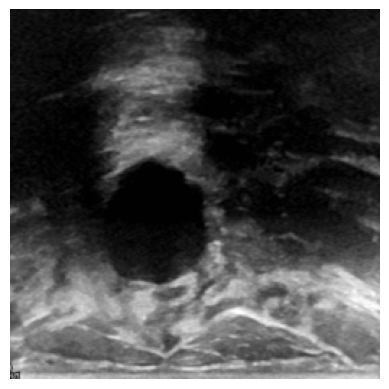

In [ ]:
image_np = orginal_image.squeeze().cpu().numpy()

# Plot the image
plt.imshow(image_np, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Optional: hide axis
plt.show()

In [15]:
#training loader

train_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0,
                'pin_memory':True
                }

test_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0,
               'pin_memory':True
                }
Validation_params = {'batch_size': 4,
                'shuffle': True,
                'num_workers': 0,
                     'pin_memory':True
                }
training_loader = DataLoader(train_df_2, **train_params)
testing_loader = DataLoader(test_df_2, **test_params)
validation_loader = DataLoader(val_df_2, **Validation_params)

In [ ]:
#dice loss
def dice_loss(pred, target, smooth = 1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection=2*(pred*target).sum()+smooth
    dominator_sum=pred.sum()+target.sum()+smooth
    dice_loss=1-((intersection+smooth)/(dominator_sum+smooth))
    return dice_loss
def bce_dice_loss(pred, target):
    bce = torch.nn.BCELoss()
    bce_loss = bce(pred, target)
    dice = dice_loss(pred, target)
    return bce_loss + dice

In [ ]:
#IUO matric function
def iou_score(output, target):
    smooth = 1e-5
    output = output.type(torch.LongTensor)
    target = target.type(torch.LongTensor)
    intersection=(output & target).float().sum((1, 2))
    union=(output | target).float().sum((1, 2))
    iou = (intersection + smooth) / (union + smooth)
    thresholded = torch.clamp(20 * (iou - 0.55), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    return thresholded.mean()

In [ ]:
#optimizer
optimizer = torch.optim.Adam(params =model.parameters(), lr=0.0001,weight_decay=1e-3 )
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 0.001, epochs=50, steps_per_epoch=len(training_loader))

##Training

In [ ]:
#training function for attention unet
def train_attention_unet(model,optimizer,loss_function,train_loader,val_loader,epochs,device,patience,scheduler):
    best_val_loss = float('inf')
    no_improvement_count = 0
    training_losses = []
    validation_losses = []
    iou_scores_train=[]
    iou_scores_val=[]
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        step = 0
        iou_train=0
        all_preds, all_labels = [], []
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for step, (images,masked_image ) in progress_bar:
            images, masked_image = images.to(device), masked_image.to(device)
            optimizer.zero_grad()
            outputs=model(images)
            threshold = 0.55
            prediction = (outputs > threshold)
            loss=loss_function(outputs,masked_image)
            iou_my=iou_score(prediction, masked_image)
            #convert to integer

            iou_my =iou_my.cpu().numpy()
            iou_train+=iou_my
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            sched.step()

            step += 1
            if step % 20 == 0:
                print(f"Epoch {epoch+1}, Step {step}, Loss: {train_loss/step:.4f}, IOU: {iou_train/step},LR:{scheduler.get_last_lr()}")
        #validation loss
        model.eval()
        val_loss = 0
        iou_val=0
        nb_val_steps = 0
        all_preds_v, all_labels_v = [], []
        with torch.no_grad():
          for val_step, (val_image, val_mask) in enumerate(val_loader):
            val_images, val_masks = val_image.to(device), val_mask.to(device)
            outputs_v = model(val_images)
            prediction_v = (outputs_v > 0.55)
            loss_v = loss_function(outputs_v, val_masks)
            val_loss += loss_v.item()
            nb_val_steps += 1
            iou_my_v=iou_score(prediction_v, val_masks)
            iou_my_v=iou_my_v.cpu().numpy()
            iou_val+=iou_my_v

        train_loss_epoch = train_loss/step
        val_loss_epoch = val_loss / nb_val_steps
        iou_train_epoch=iou_train/step
        iou_val_epoch=iou_val/nb_val_steps
        training_losses.append(train_loss_epoch)
        validation_losses.append(val_loss_epoch)
        iou_scores_train.append(iou_train_epoch)
        iou_scores_val.append(iou_val_epoch)
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss_epoch:.4f}, Validation Loss: {val_loss_epoch}")
        print(f"Epoch {epoch+1}/{epochs}, Training IOU: {iou_train_epoch:.4f}, Validation IOU: {iou_val_epoch}")
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            print(f"Best validation loss {best_val_loss}")
            #torch.save(model.state_dict(), model_save_path)
        else:
            no_improvement_count += 1
            if no_improvement_count >= patience:
              print("Early stopping triggered. No improvement in validation loss for {} epochs.".format(patience))
              break
    plt.figure(figsize=(20,8))
    plt.subplot(1,2,1)
    plt.title("Model Loss")
    plt.plot(training_losses, label="Training")
    plt.plot(validation_losses, label="Validtion")
    plt.legend()
    plt.grid()


    plt.subplot(1,2,2)
    plt.title("Model IoU")
    plt.plot(iou_scores_train, label="Training")
    plt.plot(iou_scores_val, label="Validtion")
    plt.legend()
    plt.grid()
    plt.show()





Epoch 1/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 1, Step 20, Loss: 1.3834, IOU: 0.2793994091451168,LR:[4.018003502391932e-05]
Epoch 1, Step 40, Loss: 1.3289, IOU: 0.3391821261495352,LR:[4.072000504313643e-05]
Epoch 1, Step 60, Loss: 1.2780, IOU: 0.38489257420102757,LR:[4.1619505001337306e-05]
Epoch 1, Step 80, Loss: 1.2442, IOU: 0.4213574154302478,LR:[4.287786014228669e-05]
Epoch 1, Step 100, Loss: 1.2162, IOU: 0.44150878056883813,LR:[4.449412651599328e-05]
Epoch 1, Step 120, Loss: 1.2131, IOU: 0.44971027684708437,LR:[4.6467091686810285e-05]
Epoch 1, Step 140, Loss: 1.1959, IOU: 0.46019599895392144,LR:[4.879527564293862e-05]
Epoch 1/50, Training Loss: 1.1895, Validation Loss: 1.0963086925054852
Epoch 1/50, Training IOU: 0.4614, Validation IOU: 0.5291734996594881
Best validation loss 1.0963086925054852


Epoch 2/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 2, Step 20, Loss: 1.0918, IOU: 0.5299316182732582,LR:[5.3408616063125225e-05]
Epoch 2, Step 40, Loss: 1.0485, IOU: 0.5400414884090423,LR:[5.6668978745799746e-05]
Epoch 2, Step 60, Loss: 1.0459, IOU: 0.5364990090330441,LR:[6.027690730969965e-05]
Epoch 2, Step 80, Loss: 1.0507, IOU: 0.5261828511953354,LR:[6.422969528188606e-05]
Epoch 2, Step 100, Loss: 1.0557, IOU: 0.5360517454147339,LR:[6.852437749453762e-05]
Epoch 2, Step 120, Loss: 1.0427, IOU: 0.5419425311187903,LR:[7.315773230925915e-05]
Epoch 2, Step 140, Loss: 1.0388, IOU: 0.541531794837543,LR:[7.81262840337803e-05]
Epoch 2/50, Training Loss: 1.0371, Validation Loss: 0.9613376102949444
Epoch 2/50, Training IOU: 0.5439, Validation IOU: 0.6383788758202603
Best validation loss 0.9613376102949444


Epoch 3/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 3, Step 20, Loss: 0.9856, IOU: 0.5833300516009331,LR:[8.704719710112495e-05]
Epoch 3, Step 40, Loss: 0.9776, IOU: 0.5898754626512528,LR:[9.288533514946636e-05]
Epoch 3, Step 60, Loss: 0.9724, IOU: 0.5916780352592468,LR:[9.904387152656884e-05]
Epoch 3, Step 80, Loss: 0.9621, IOU: 0.6036608587950468,LR:[0.00010551818643141607]
Epoch 3, Step 100, Loss: 0.9638, IOU: 0.5929482164978981,LR:[0.00011230342318301306]
Epoch 3, Step 120, Loss: 0.9571, IOU: 0.591387506822745,LR:[0.00011939449186360626]
Epoch 3, Step 140, Loss: 0.9680, IOU: 0.5780084859047617,LR:[0.00012678607313686423]
Epoch 3/50, Training Loss: 0.9597, Validation Loss: 0.932711776934172
Epoch 3/50, Training IOU: 0.5812, Validation IOU: 0.5913085639476776
Best validation loss 0.932711776934172


Epoch 4/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 4, Step 20, Loss: 0.8939, IOU: 0.5560009703040123,LR:[0.00013962433339508582]
Epoch 4, Step 40, Loss: 0.9220, IOU: 0.5546972520649434,LR:[0.00014778487047412126]
Epoch 4, Step 60, Loss: 0.9267, IOU: 0.5685969909032186,LR:[0.00015622462321877092]
Epoch 4, Step 80, Loss: 0.9076, IOU: 0.5752380210906267,LR:[0.00016493726058283752]
Epoch 4, Step 100, Loss: 0.8916, IOU: 0.5739033034443856,LR:[0.0001739162468168367]
Epoch 4, Step 120, Loss: 0.8931, IOU: 0.5760310689608256,LR:[0.0001831548463707627]
Epoch 4, Step 140, Loss: 0.8887, IOU: 0.5770026326179505,LR:[0.0001926461289467336]
Epoch 4/50, Training Loss: 0.8849, Validation Loss: 0.8332821475832086
Epoch 4/50, Training IOU: 0.5773, Validation IOU: 0.6118780547066739
Best validation loss 0.8332821475832086


Epoch 5/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 5, Step 20, Loss: 0.7894, IOU: 0.5956054493784905,LR:[0.00020884015531895048]
Epoch 5, Step 40, Loss: 0.8328, IOU: 0.6156152099370956,LR:[0.00021896612692503278]
Epoch 5, Step 60, Loss: 0.8641, IOU: 0.6033284296592076,LR:[0.00022931791786669664]
Epoch 5, Step 80, Loss: 0.8595, IOU: 0.5810534484684468,LR:[0.00023988776279006813]
Epoch 5, Step 100, Loss: 0.8469, IOU: 0.5754618966579437,LR:[0.0002506677327689653]
Epoch 5, Step 120, Loss: 0.8429, IOU: 0.5784545737008254,LR:[0.0002616497412527509]
Epoch 5, Step 140, Loss: 0.8503, IOU: 0.5696581872446197,LR:[0.0002728255501324244]
Epoch 5/50, Training Loss: 0.8512, Validation Loss: 0.7977289400602642
Epoch 5/50, Training IOU: 0.5646, Validation IOU: 0.6235351374274806
Best validation loss 0.7977289400602642


Epoch 6/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 6, Step 20, Loss: 0.8085, IOU: 0.5431542798876763,LR:[0.000291666971033528]
Epoch 6, Step 40, Loss: 0.8216, IOU: 0.5720800496637821,LR:[0.0003033154391108272]
Epoch 6, Step 60, Loss: 0.7697, IOU: 0.5940315465132395,LR:[0.0003151264522302208]
Epoch 6, Step 80, Loss: 0.7645, IOU: 0.5891430381685495,LR:[0.0003270911504082524]
Epoch 6, Step 100, Loss: 0.7740, IOU: 0.575677709877491,LR:[0.0003392005583752446]
Epoch 6, Step 120, Loss: 0.7543, IOU: 0.5854231519003709,LR:[0.00035144559230805973]
Epoch 6, Step 140, Loss: 0.7585, IOU: 0.5809563087565558,LR:[0.0003638170666442937]
Epoch 6/50, Training Loss: 0.7617, Validation Loss: 0.7475853813321967
Epoch 6/50, Training IOU: 0.5793, Validation IOU: 0.639047047025279
Best validation loss 0.7475853813321967


Epoch 7/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 7, Step 20, Loss: 0.7710, IOU: 0.5672021374106407,LR:[0.00038448170611688837]
Epoch 7, Step 40, Loss: 0.7321, IOU: 0.583034648001194,LR:[0.0003971431343952796]
Epoch 7, Step 60, Loss: 0.7304, IOU: 0.5810628061493238,LR:[0.0004098967232517448]
Epoch 7, Step 80, Loss: 0.7309, IOU: 0.5788012515753508,LR:[0.0004227329056334725]
Epoch 7, Step 100, Loss: 0.7192, IOU: 0.5818251743912697,LR:[0.0004356420525304537]
Epoch 7, Step 120, Loss: 0.7323, IOU: 0.578094054510196,LR:[0.00044861448019864513]
Epoch 7, Step 140, Loss: 0.7491, IOU: 0.5724574293409075,LR:[0.00046164045742419046]
Epoch 7/50, Training Loss: 0.7414, Validation Loss: 0.8115313021760238
Epoch 7/50, Training IOU: 0.5763, Validation IOU: 0.4923262627501237


Epoch 8/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 8, Step 20, Loss: 0.8314, IOU: 0.5161718681454659,LR:[0.0004832243868786565]
Epoch 8, Step 40, Loss: 0.7683, IOU: 0.5582617051899433,LR:[0.000496344929402035]
Epoch 8, Step 60, Loss: 0.7523, IOU: 0.5768033698201179,LR:[0.0005094832166804172]
Epoch 8, Step 80, Loss: 0.7209, IOU: 0.5817553516477346,LR:[0.0005226293930810349]
Epoch 8, Step 100, Loss: 0.7269, IOU: 0.5787880662083625,LR:[0.0005357735970531266]
Epoch 8, Step 120, Loss: 0.7426, IOU: 0.5808764420449734,LR:[0.0005489059685255401]
Epoch 8, Step 140, Loss: 0.7368, IOU: 0.5821344639573779,LR:[0.0005620166563032247]
Epoch 8/50, Training Loss: 0.7294, Validation Loss: 0.7155715446723135
Epoch 8/50, Training IOU: 0.5838, Validation IOU: 0.5870065453805422
Best validation loss 0.7155715446723135


Epoch 9/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 9, Step 20, Loss: 0.8586, IOU: 0.5749316200613975,LR:[0.0005835757348588999]
Epoch 9, Step 40, Loss: 0.7710, IOU: 0.600605446100235,LR:[0.000596581462741938]
Epoch 9, Step 60, Loss: 0.7657, IOU: 0.6055973023176193,LR:[0.0006095297433521575]
Epoch 9, Step 80, Loss: 0.7260, IOU: 0.6074328329414129,LR:[0.0006224108635895189]
Epoch 9, Step 100, Loss: 0.7184, IOU: 0.6048046579957008,LR:[0.0006352151607340638]
Epoch 9, Step 120, Loss: 0.7186, IOU: 0.599514132986466,LR:[0.0006479330296943644]
Epoch 9, Step 140, Loss: 0.7190, IOU: 0.5981765917369297,LR:[0.0006605549302127441]
Epoch 9/50, Training Loss: 0.7183, Validation Loss: 0.8229114491688577
Epoch 9/50, Training IOU: 0.5978, Validation IOU: 0.6746247442145097


Epoch 10/50:   0%|          | 0/153 [00:00<?, ?it/s]

Epoch 10, Step 20, Loss: 0.7737, IOU: 0.5485497906804084,LR:[0.0006811461040361377]
Epoch 10, Step 40, Loss: 0.7189, IOU: 0.5713012523949146,LR:[0.0006934681107040133]
Epoch 10, Step 60, Loss: 0.7369, IOU: 0.5818424299359322,LR:[0.0007056599909741397]
Epoch 10, Step 80, Loss: 0.7179, IOU: 0.5868896294385195,LR:[0.0007177125991571164]
Epoch 10, Step 100, Loss: 0.7121, IOU: 0.5860868963599205,LR:[0.0007296168940379333]
Epoch 10, Step 120, Loss: 0.7269, IOU: 0.5835668761283159,LR:[0.0007413639456582001]
Epoch 10, Step 140, Loss: 0.7401, IOU: 0.5829624538975102,LR:[0.0007529449420149188]
Epoch 10/50, Training Loss: 0.7461, Validation Loss: 0.8818530440330505
Epoch 10/50, Training IOU: 0.5815, Validation IOU: 0.6680560849214855
Early stopping triggered. No improvement in validation loss for 3 epochs.


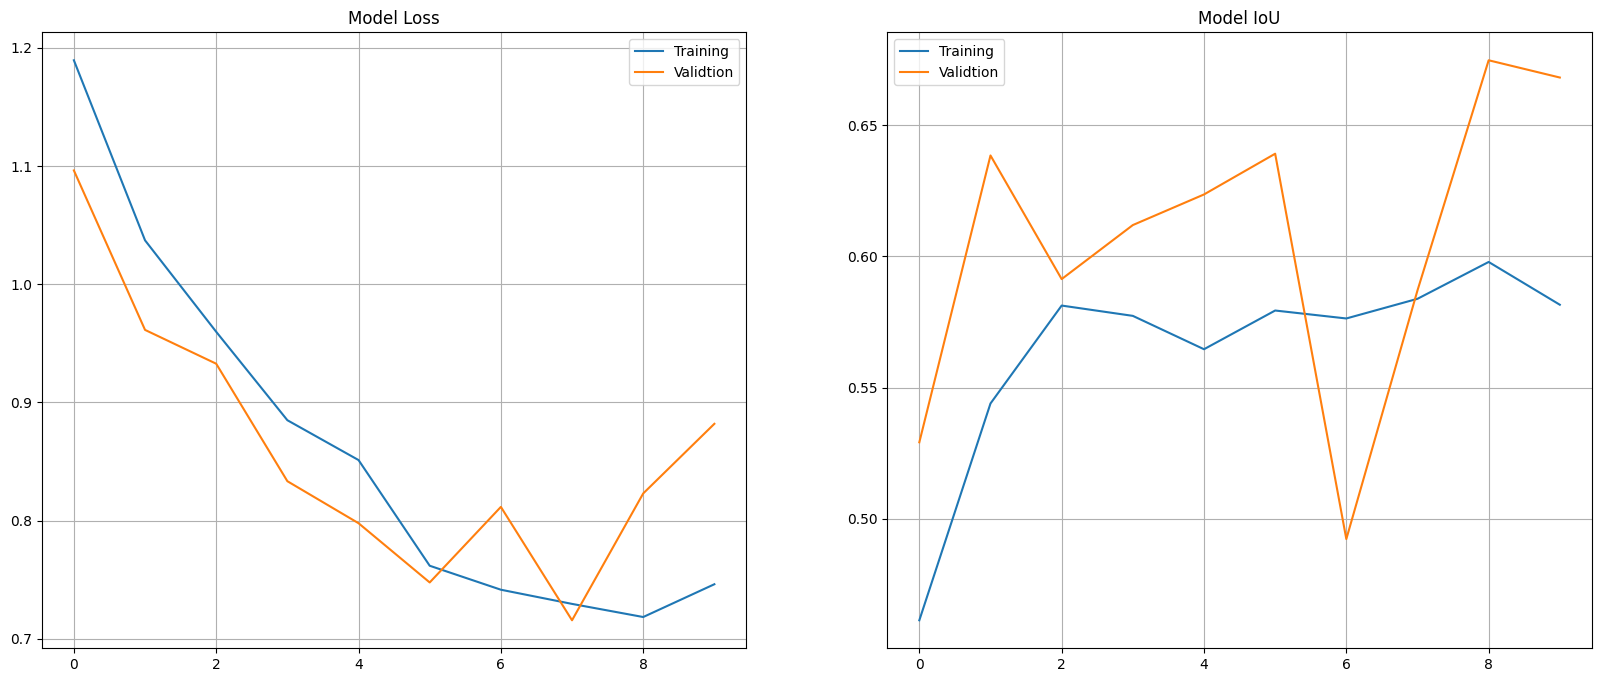

In [ ]:
#training
train_attention_unet(model,optimizer,bce_dice_loss,training_loader,validation_loader,50,device,3,sched)

The results on the validation data outperform those on the training data in terms of IoU. This suggests that the model has the potential to achieve much better performance if provided with additional training data. However, the loss behavior is not ideal, as it increases during the final epochs, ultimately triggering the early stopping rule.

##Testing

In [ ]:
#test function
def test_model_attention_unet(model,loss_function, test_loader, device):
    model.eval()
    test_loss = 0
    iou_scores_test = 0
    with torch.no_grad():
        for step, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)
            outputs_test = model(images)
            loss=loss_function(outputs_test,masks)
            test_loss += loss.item()
            threshold = 0.55
            prediction_test = (outputs_test > threshold)
            iou_my=iou_score(prediction_test, masks)
            iou_my=iou_my.cpu().numpy()
            iou_scores_test+=iou_my
    iou_scores_test_final=iou_scores_test/len(test_loader)
    test_loss_final = test_loss / len(test_loader)
    print(f"Test Loss: {test_loss_final:.4f}, Test IOU: {iou_scores_test_final}")


In [ ]:
test_model_attention_unet(model,bce_dice_loss,testing_loader,device)

Test Loss: 1.0376, Test IOU: 0.6532323777675628


(4, 256, 256)
(4, 256, 256)
(4, 256, 256)
(4, 256, 256)


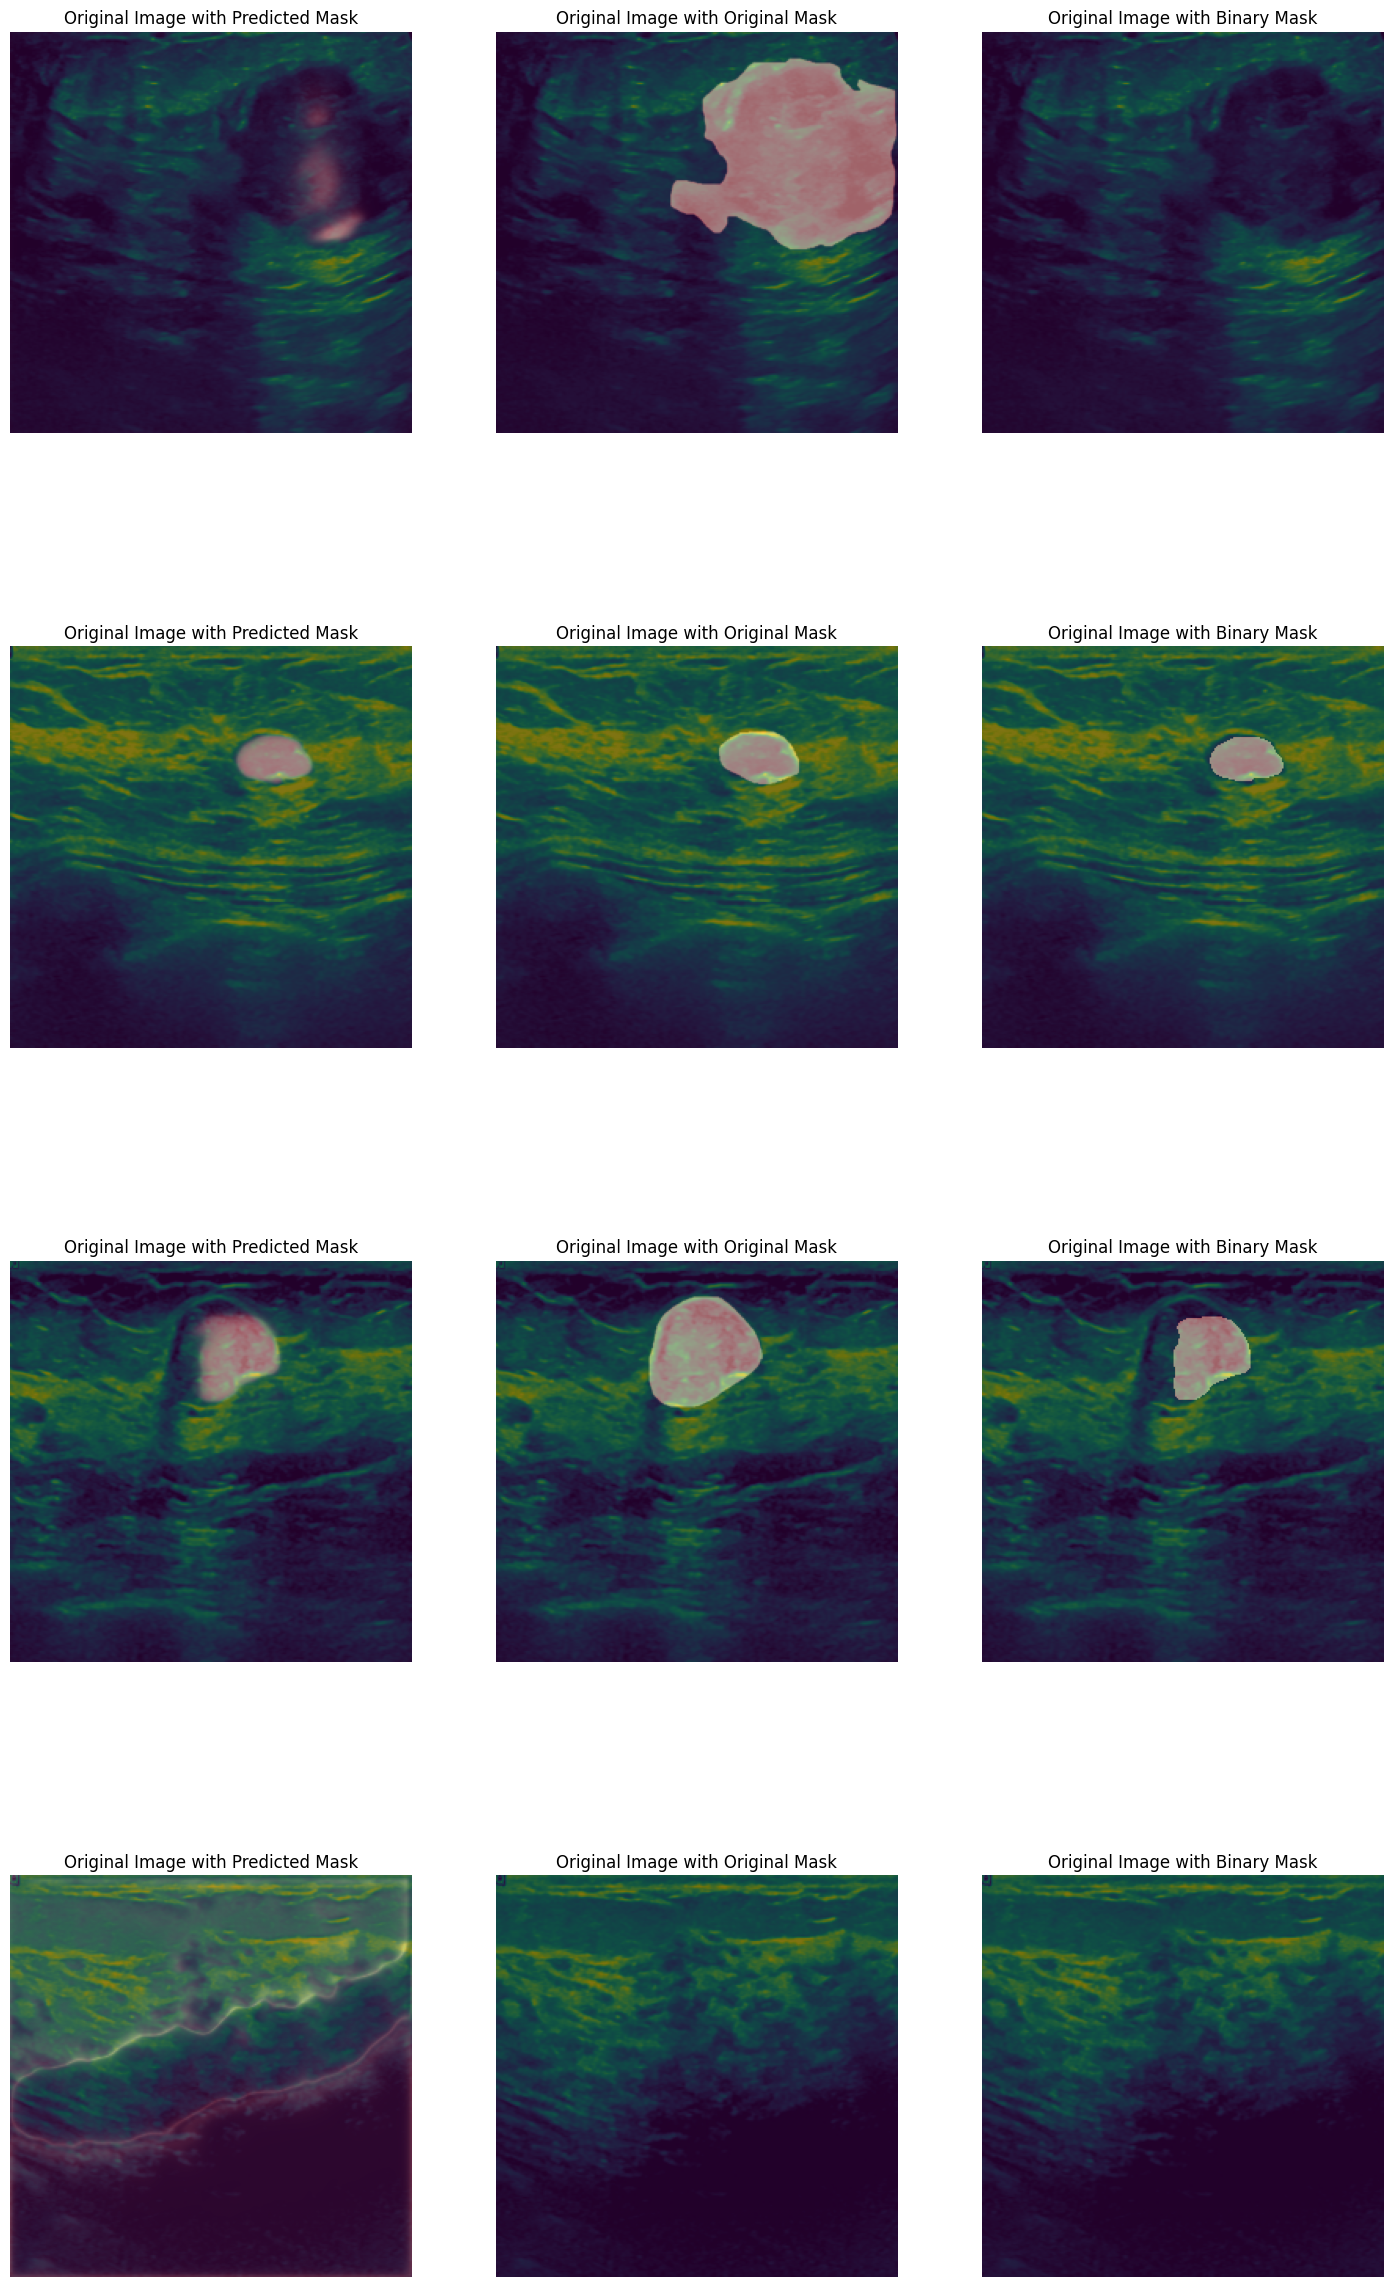

In [ ]:
model.eval()
with torch.no_grad():
    for step, (images, masks) in enumerate(testing_loader):
        if step == 1:
            break
        images, masks = images.to(device), masks.to(device)
        outputs_test = model(images)
        threshold = 0.55
        prediction_test = (outputs_test > threshold)
        np_images_original = images.cpu().detach().numpy()
        np_images = np.squeeze(np_images_original, axis=1)
        np_mask=np.squeeze(masks.cpu().detach().numpy(),axis=1)
        np_prediction_test = np.squeeze(prediction_test.cpu().detach().numpy(), axis=1)
        outputs_np = np.squeeze(outputs_test.cpu().detach().numpy(), axis=1)

print(np_images.shape)
print(np_mask.shape)
print(np_prediction_test.shape)
print(outputs_np.shape)

#plotting the predicted mask , predicted binary mask and the mask on original images
fig, axes = plt.subplots(4, 3, figsize=(15, 25))
fig.tight_layout(pad=3.0)

for i in range(4):
    # Original image with predicted mask
    axes[i, 0].imshow(np_images[i])
    axes[i, 0].imshow(outputs_np[i], alpha=0.5, cmap='copper')
    axes[i, 0].set_title("Original Image with Predicted Mask")
    axes[i, 0].axis('off')

    # Original image with original mask
    axes[i, 1].imshow(np_images[i])
    axes[i, 1].imshow(np_mask[i], alpha=0.5, cmap='copper')
    axes[i, 1].set_title("Original Image with Original Mask")
    axes[i, 1].axis('off')

    # Original image with binary mask
    axes[i, 2].imshow(np_images[i])
    axes[i, 2].imshow(np_prediction_test[i], alpha=0.5, cmap='copper')
    axes[i, 2].set_title("Original Image with Binary Mask")
    axes[i, 2].axis('off')

plt.show()

The results on the validation data outperform those on the training data in terms of IoU. This suggests that the model has the potential to achieve much better performance if provided with additional training data. However, the loss behavior is not ideal, as it increases during the final epochs, ultimately triggering the early stopping rule.

The results on the test data are reasonably good, as indicated by the IoU score. In the selected images, we observe some accurate "hits" in the predicted masks. While the predictions are not perfect, they are promising and demonstrate potential for further improvement.